## Goal

The goal of this project is to predict an NFL receiver's separation at the time of pass arrives. I will be using the NFL's player-tracking data set from the last 3 seasons (2017-2019) to create these predictions.

## Motivation

All receivers are NOT built equal. Receivers like Tyler Lockett (Seahawks) are short, quick, and line up often in the 'slot.' Others, like Cooper Kupp (Rams), are slightly bigger, line up 'tight' to the line of scrimmage, and often run shallow routes, not far downfield. Different from Kupp and Lockett are the physical, large-framed receivers (Allen Robinson, Bears or Mike Evans, Bucs) whom excel in tight windows, often line up out 'Wide', and are usually smothered by the opposing team's best cornerback. Due to these differences, I believe receiver separation should be treated on a play-by-play basis, and thus predictions in separation should change relative to these differences. 

For example, my intuition says that a receiver that lines up out 'wide', is pressed at the line of scrimage, and is targeted 20 yards downfield should have little to no separation when the pass arrives. In contrast, a reciver that lines up in the slot and is targeted 3 yards *behind* the line of scrimmage, and had 10 yards of cushion at the time of snap should expect to have more separation.


Since these players have different body types, abilities, team roles, and responsibilities, I don't think it's fair to compare their receiver separations to say "Hey, receiver X is better at creating separation than receiver Y because he averages more separation." To try and account for this, I want to create a predicted separation metric that, once compared to their actual separation, will be able to tell a more interesting story that is RELATIVE to their in-play situation/team role. 

When aggregated over a course of a game, season, or career, this 'expected separation' value will bring context into the players TRUE ability to separate given their in-play circumstances, or at least give descriptive context into the situations a certain receiver sees. 

In [1]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
import fancyimpute 
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms

# Machine Learning Modeling and Cross-Validation/Accuracy 
import sklearn

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
LoadData = "../data/ExpSepPos.csv"

df = pd.read_csv(LoadData, index_col = False)

random_state = 1

In [3]:
print(df.shape)
print(max(df['GameId']))
print(min(df['GameId']))
df.head()

(53710, 31)
2020020200
2017090700


,GameId,PlayId,Season,Team,Receiver,Nearest_Defender,Nearest_Def_Position,Opp,Wk,Qtr,...,Air_Dist,Air_Time,TTT,Separation,QB_Separation,QBP,QB_Scramble_Yds,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist
0,2017102910,2814,2017,PIT,JuJu Smith-Schuster,Quandre Diggs,SS,DET,8,3,...,33.119846,1.539,2.756,1.785385,2.084347,0,4.12,26.303329,1.145455,37.540001
1,2018112509,2475,2018,PIT,JuJu Smith-Schuster,Bradley Roby,CB,DEN,12,3,...,37.510450,2.202,2.436,2.674790,1.540033,1,7.09,12.303331,3.763636,40.230003
2,2017111208,2731,2017,LA,Robert Woods,Johnathan Joseph,CB,HOU,10,3,...,52.871040,2.633,3.135,3.966674,3.386576,0,7.52,17.230000,1.247727,58.880001
3,2019120800,2777,2019,ATL,Olamide Zaccheaus,Donte Jackson,CB,CAR,14,3,...,49.233444,3.018,2.771,0.910220,2.814427,0,5.20,19.433328,1.329546,56.439999
4,2019101310,1630,2019,NYJ,Robby Anderson,Jeff Heath,SS,DAL,6,2,...,46.187710,2.636,3.003,1.676305,1.471224,1,6.58,15.103330,3.477273,57.060001


Our Dataset spans 3 years (2017-2020) and includes regular and postseason games. We have a total of 53,710 total passes with non-null receiver separations to work with. 

I will go through what each of these columns represent, and their definitions, when I analyze each of them further down in this notebook.

# Predicting Receiver Separation

## Data Cleaning

- Handle missing values
    - Discuss various ways to impute missing/null values
    - Remove Rows with missing cushion?
- Handle Outliers

## Data Exploration

- Feature Analysis
    - Numerical Features
        - Discrete Features
        - Continuous Features
    - Categorical Features
- Feature Engineering
    - Nearest Defender Position into broader groups
    
## Model Selection

- Choosing the right Model
    - Linear Regression
        - LASSO Regression
        - Ridge Regression
        - Huber Loss Regressor
    - Random Forest
    - eXtreme Gradient Boosting
    - Light Gradient Boosting 

In [4]:
# Describing all the Numerical Features
df.describe()
COLS = df.columns.to_list()

## Dropping non-relevant features 

Right off the bat, I think a lot the variables in this dataset will not be useful in predicting reciever separation. Also, there are a lot features in this set that describe the outcome of the event. These features (Pass Yards, TD, INT) cannot be used in prediction. For features that I am skeptical of, but not sure about their effect, I will leave alone, otherwise I will drop all non-essential features below.

In [5]:
IrrelevantCols = ['GameId', 'PlayId', 'Season', 'Wk', 'Cmp', 'Team', 'Receiver', 'Nearest_Defender', 'Opp', 'Wk', 'Cmp', 'Pass Yds','TD', 'INT',
 'Comp_Prob', 'Separation', 'Time', 'QB_Scramble_Yds', 'TTT', 'QB_Speed_at_Pass', 'QBP']

# Drop all irrelevant columns and output variable (separation)
Features = df.drop(IrrelevantCols, axis = 1)

#Create 1-dimensional array of Target variable (separation)
Target = df['Separation']

#Output top 5 rows of Features Dataframe
cols = len(Features.columns)
print('We are left with ' + str(cols) + ' features to help with prediction')
Features.head()


We are left with 12 features to help with prediction


,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,Receiver_Dist_From_Sideline,EZ_Dist
0,SS,3,3,9,Slot,3.66,24.54,33.119846,1.539,2.084347,26.303329,37.540001
1,CB,3,1,10,Wide,2.66,27.23,37.510450,2.202,1.540033,12.303331,40.230003
2,CB,3,2,8,Wide,10.23,42.88,52.871040,2.633,3.386576,17.230000,58.880001
3,CB,3,3,8,Wide,6.74,39.44,49.233444,3.018,2.814427,19.433328,56.439999
4,SS,2,1,10,Wide,3.23,39.06,46.187710,2.636,1.471224,15.103330,57.060001


Here are the reasons for why I chose NOT to include the columns that I dropped. 

1. **Time** - Time is a string in this dataset, I will address it later, it may be helpful, but I want to remove it for now
2. **QB_Scramble_Yds** - Did analysis on this, no clear relationship. No model that I trained that used it effectively and thought it was valuable in prediction
3. **QB_Speed_at_Pass** - Same as QB scramble yards. It was hard to pinpoint exactly why a fast/slow QB would help create more/less separation, so I dropped it
4. **QBP** - We already have QB Separation, so no need to double-down.
5. **TTT** - Also did analysis on this, time to throw had no tangible relationship to separation

# Target Variable (Separation)

Let's take a look at our target variable, Reciever Separation



The Kurtosis of the distribution of the target variable is 1.7
The Skew of the distribution of the target variable is 1.2


count    53710.000000
mean         3.244240
std          2.435761
min          0.020000
25%          1.292652
50%          2.613341
75%          4.589033
max         19.226980
Name: Separation, dtype: float64

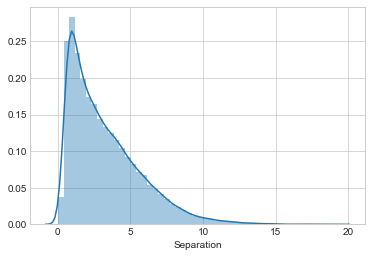

In [6]:
# How Normally Distributed is our Output Variable (Separation)

plt.style.use('seaborn-whitegrid')
Fig = sns.distplot(df['Separation'])

K = round(stats.kurtosis(df['Separation']),1)
S = round(stats.skew(df['Separation']), 1)
p_value = stats.shapiro(df['Separation'])[1]
    
print('\n')
print('The Kurtosis of the distribution of the target variable is ' + str(K))
print('The Skew of the distribution of the target variable is ' + str(S))

df['Separation'].describe()


As we can see, our data is **skewed to the right**, or positively skewed, making the distribution of Separation noticably non-normal (non-gaussian). 

Based on my understanding of the game of football, the only time we would expect receiver separations to be greater than 10 yards, are in instances where the targeted player is not a current threat to gain yards (passes targeting receivers behind the line of scrimmage) OR blatant busts in coverage.

Since the distribution of Separation is so skewed to the right, I decided to use the Tukey method (Tukey JW., 1977) to detect ouliers, which is based on quartiles as opposed to using standard deviations or anything of the like. First we find the interquartile range, comprised between the 1st and 3rd quartile of the distribution (IQR). An outer fence outlier is any Separation value outside the IQR +/- 1 outlier steps. 1 Outlier step is defined as 3 times the interquartile range.

In this case, the only outliers exist beyond the 3rd Quartile (because there are no outliers below Q1), which is **14.5 yards**. 

Since we do not want to predict a receiver will be faced with 'busted' coverage, I will now drop all rows with a separation value above 14.5 yards. 

In [7]:
# 1st quartile (25%)
Q1 = np.percentile(df['Separation'], 25)
# 3rd quartile (75%)
Q3 = np.percentile(df['Separation'],75)
# Interquartile range (IQR)
IQR = Q3 - Q1
        
# outlier step
outlier_step = 3 * IQR

#Upper outer fence
outlier_step + Q3

#Tukey's Outer Upper Fence
Upper_Fence = outlier_step + Q3
Upper_Fence

14.478175490000002

In [8]:
df = df[df['Separation'] <= Upper_Fence]

In [9]:
left = len(df)
print('We dropped ' + str(53710-left) + ' rows with a separation over 14.5 yards, or ' + str(round(((53710-left)/53710)*100,2) )+'% of our dataset')

We dropped 49 rows with a separation over 14.5 yards, or 0.09% of our dataset


## Missing Values

In [10]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
missing_values_table(Features)

Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Cushion,14125,26.3
Receiver_Location,108,0.2


Of the 14125 missing cushion values, how many were from targets from receivers who lined up in the backfield?

In [11]:
Cush = df[df['Cushion'].isna()]
Cush['Receiver_Location'].value_counts()

Backfield    9826
Slot         2739
Tight        1329
Wide          113
Name: Receiver_Location, dtype: int64

In [12]:
Backfield = df[(df['Receiver_Location'] == 'Backfield')][['Cushion', 'Separation']]
print('There were ' + str(len(Backfield)) + ' plays where the player who lined up in the backfield was targeted')
print('The average Cushion of a player who lines up in the Backfield is ' + str(Backfield['Cushion'].mean()))
print('The average Separation of a player who lines up in the Backfield is ' + str(round(Backfield['Separation'].mean(), 2)))


There were 9826 plays where the player who lined up in the backfield was targeted
The average Cushion of a player who lines up in the Backfield is nan
The average Separation of a player who lines up in the Backfield is 4.75


Every target to a player that lined up in the *'Backfield'* in this dataset has a **null cushion value**. This makes sense, as they are far from the line of scrimmage, often behind, or to the side of the QB at the time of snap, and roughly 5-10 yards behind the line of scrimmage when the ball is snapped, making it nearly impossible to determine who is covering them, if anyone specific at all. 

If all of the Backfield targets are missing a cushion value, this means that this type of data is *Missing Not at Random* ([relevant wiki](https://en.wikipedia.org/wiki/Missing_data#Missing_not_at_random)). With data that is missing Not at Random, it is not 'ignorable' since removing all of these rows would drastically change the distribution of Separation values. 

That being said, the goal of this project is try to predict a players separation as accurately as possible, and if we remove just the backfield targets, we don't necessarily lose any insight in how to predict Separation for non-backfield targets. 

## Ways to deal with missing Cushion values 
 1. Impute the missing values
     - Replace missing values with a summary statistic (like a mean/median)
         - This would introduce a lot bias into the distribution of Cushion in the whole data set (25% would be one number)
     - Use something like kNN (K-nearest neighbors) or other ML model to predict Cushion 
         - 'Backfield' rows have 0 cushion values
         - We have to use other Features in the dataset to draw from
 2. Remove all rows where the receiver location is 'Backfield' 
     - This will remove ~10,000 rows, losing data is never ideal, but sometimes necessary 
     - Predicting non-backfield targets will likely be more accurate after removing these rows
     - Remember our goal: creating a way to compare receivers
         - Since RBs are the primary receiver out of the backfield, I am not as concerned about their ability to create separation

Let's take a look at the distribution of Separations grouped by Receiver Location to see if they are differences:

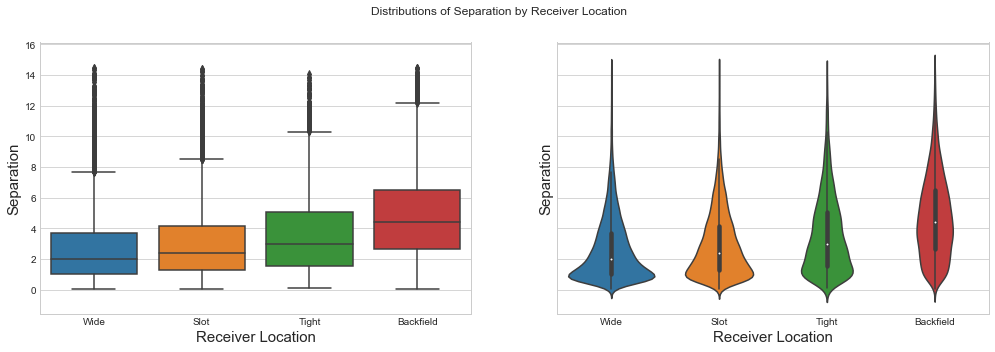

In [13]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(17,5))

fig.suptitle('Distributions of Separation by Receiver Location')
sns.boxplot(x="Receiver_Location", y="Separation", data=df, ax = ax1, order=['Wide', 'Slot', 'Tight', 'Backfield'])
A =sns.violinplot(x="Receiver_Location", y="Separation", data=df, ax = ax2, order=['Wide', 'Slot', 'Tight', 'Backfield'])

ax1.set_ylabel('Separation', fontsize = 15)
ax1.set_xlabel('Receiver Location', fontsize = 15)
ax2.set_xlabel('Receiver Location', fontsize = 15)
A = ax2.set_ylabel('Separation', fontsize = 15)

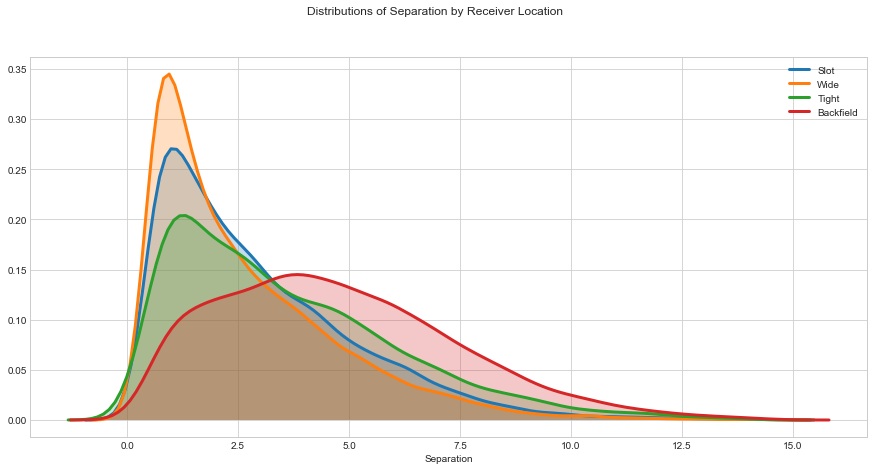

In [14]:
# List of four recevier locations to plot
RecLocations = list(df['Receiver_Location'].unique())

fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Receiver Location')

# Iterate through the four receiver locations
for loc in RecLocations:
    # Subset to the Receiver location
    subset = df[df['Receiver_Location'] == loc]
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = loc)
    


In [15]:
print('The mean separation of Backfield targets is ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].std(), 1))+ ' yards')
print('The mean separation of NON-Backfield targets is ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].std(), 1))+ ' yards')

The mean separation of Backfield targets is 4.7 yards, +/- 2.7 yards
The mean separation of NON-Backfield targets is 2.9 yards, +/- 2.2 yards


### Backfield Targets

As we can see, Backfield targets have a **considerably higher** average separation and a distinctly different distribution from non-Backfield targets.

This makes sense, as receivers targeted in the backfield do not have pre-snap cushions, meaning that no one is lined up close to them at the time of snap. Since backfield targets have no one near them at the time of snap, receivers targeted in the backfield are often wide open at the time the pass arrives. This is because the defense either hasn't had enough time to get to the backfield to gaurd the player, or the player does not pose as big of a threat to the defense as the rest of the receivers, so the defense does not guard them as closely. 

Let's check this to see if our assumptions are correct - 

*Are targets to receivers in the backfield shorter (less air yards) and therefore warrant more separation?*



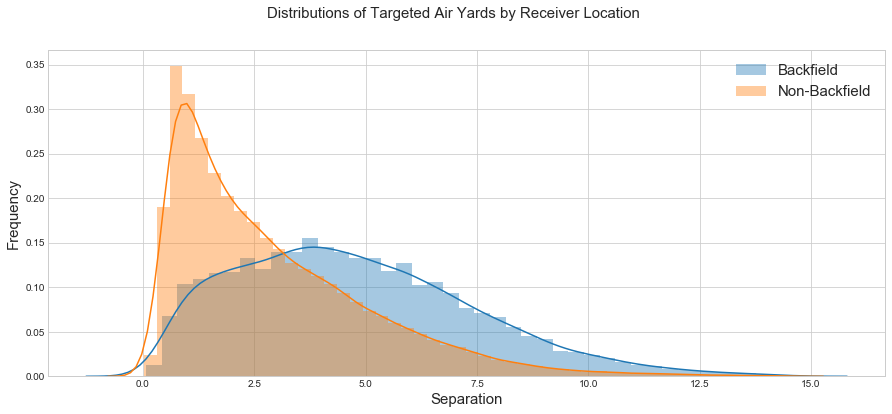

In [16]:
# List of Locations to compare
RecLocations = ['Backfield', 'Non-Backfield']

#Separate dataframes into Backfield and Non-Backfield Dataframes
Bkfd = df[df['Receiver_Location'] == 'Backfield']
NonBkfd = df[df['Receiver_Location'] != 'Backfield']

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Targeted Air Yards by Receiver Location', fontsize = 15)

# Iterate through the four receiver locations
for loc in RecLocations:
    # Subset to the Receiver location
    if loc == 'Backfield':
        subset = Bkfd
    else:
        subset = NonBkfd
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, label = loc)
    ax.legend(loc=1, prop={'size': 15})
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_xlabel('Separation', fontsize = 15)

In [17]:
print('Average Backfield Target: ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')
print('Average Non-Backfield Target: ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')

Average Backfield Target: 0.04 yards downfield
Average Non-Backfield Target: 10.06 yards downfield


### Dropping all rows for Targets in the Backfield

As we thought, backfield targets are markedly different from non-backfield targets, and exist almost exclusively 5 yards behind (or beyond) the line of scrimmage, while non-backfield targets occur downfield far more frequently. 


Since **all** of the cushion values are missing for targets to recievers who line up in the backfield, and they they usually are not indicative of anything the receiver is inherently doing to create separation, I am choosing to drop all rows targeting receivers who line up in the 'Backfield'

In [18]:
NB_Features = Features[Features['Receiver_Location'] != 'Backfield']
print(len(NB_Features))
missing_values_table(NB_Features)

43864
Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Cushion,4279,9.8
Receiver_Location,108,0.2


## Drop all Missing Receiver Location Rows

Since the Missing Receiver_Locations represent ~0.2% of our data set (108 samples), we can comfortably drop those offending rows.

In [19]:
NB_Features = NB_Features[NB_Features['Receiver_Location'].notnull()]
print(len(NB_Features))
missing_values_table(NB_Features)

43756
Your selected dataframe has 12 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Cushion,4190,9.6


We are left with 4190 misssing cushion values. 

These missing values, unlike the missing cushion values for 'Backfield' Targets, are *'missing at random'*. There is nothing in the dataset that would indicate that these cushions can be inferred from another feature, so I want to look into a way to impute these values effectively and efficiently. 

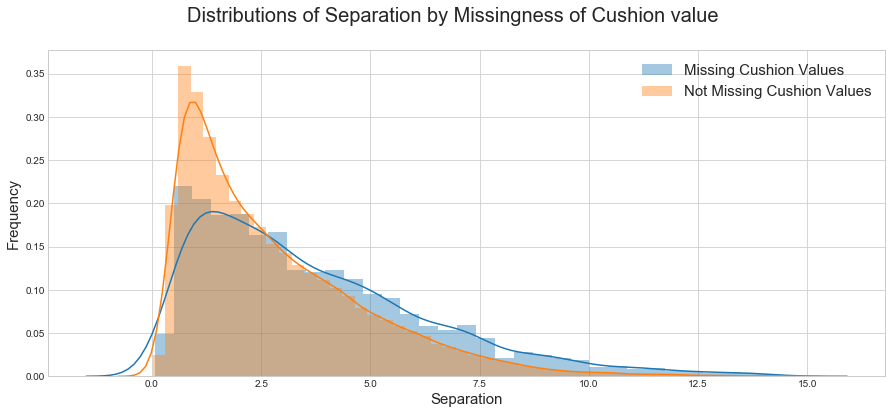

In [20]:
# List of two types of data to plot
DataTypes = ['Missing Cushion Values', 'Not Missing Cushion Values']

#Create dataframe with just non-Backfield targets
df_1 = df[df['Receiver_Location'] != 'Backfield']

#Separate dataframes into missing and non-missing Dataframes
M = df_1[df_1['Cushion'].isna()]
NM = df_1[df_1['Cushion'].notnull()]

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Missingness of Cushion value', fontsize = 20)

# Iterate through the two datatypes (missing and non-missing)
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Missing Cushion Values':
        subset = M
    else:
        subset = NM
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, label = loc)
    ax.legend(loc=1, prop={'size': 15})
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_xlabel('Separation', fontsize = 15)
    

In [21]:
print('Mean Separation w/ missing Cushion: ' + str(round(M['Separation'].mean(), 2)) + ' yards')
print('Mean Separation w/ non-missing Cushion: ' + str(round(NM['Separation'].mean(), 2)) + ' yards')

Mean Separation w/ missing Cushion: 3.7 yards
Mean Separation w/ non-missing Cushion: 2.81 yards


This makes intuitive sense, as we could imagine that targeting receviers who had no-one lined up across from them at the time of snap might lead to larger separation values. 

Let's look into this a little bit further to confirm our suspicions:

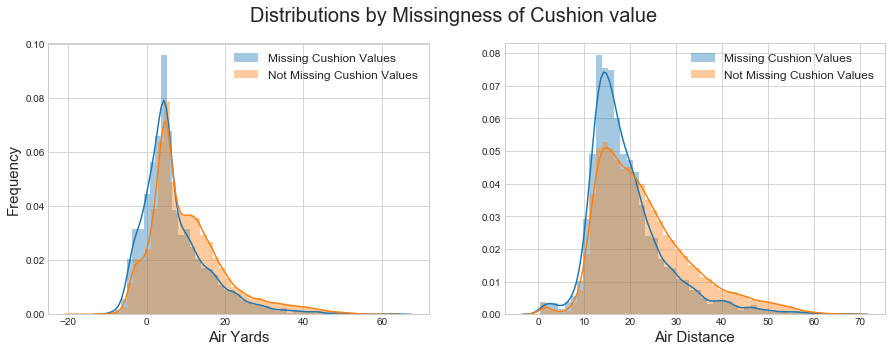

In [22]:
# List of two types of data to plot


fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Distributions by Missingness of Cushion value', fontsize=20)


# Iterate through the four receiver locations
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Missing Cushion Values':
        subset = M
    else:
        subset = NM
    
    # Draw the density plots
    sns.distplot(subset['Air_Yds'], ax = ax1, label = loc)
    sns.distplot(subset['Air_Dist'], ax = ax2, label = loc)

    ax1.legend(loc=1, prop={'size': 12})
    ax2.legend(loc=1, prop={'size': 12})
    ax1.set_xlabel('Air Yards', fontsize=15)
    ax2.set_xlabel('Air Distance', fontsize=15)
    ax1.set_ylabel('Frequency', fontsize=15)

In [23]:
Miss = np.array([round(M['Air_Yds'].mean(), 1), round(NM['Air_Yds'].mean(), 1)])
NotMiss = np.array([round(M['Air_Dist'].mean(), 1), round(NM['Air_Dist'].mean(), 1)])
MNS = np.array(['Missing Cushion', 'Not Missing Cushion'])
df_Missingness = pd.DataFrame(); df_Missingness['Avg Air Yards']=pd.Series(Miss) ;df_Missingness['Avg Air Distance']=pd.Series(NotMiss)
df_Missingness['Missingness']=pd.Series(MNS) ;df_Missingness.set_index('Missingness')

,Avg Air Yards,Avg Air Distance
Missingness,,
Missing Cushion,7.2,19.3
Not Missing Cushion,10.4,23.1


When players line up with no cushion, they often are targeted **closer to the line of scrimmage** (7.2 yards downfield vs 10.4) and **closer to where the pass was thrown** (19.3 yards as the crow flies vs. 23.1 yards) 

## Test to see if Distributions are statistically different from each other

We have suspicions that these two samples sets (rows with/without missing Cushion values) are statistically different, but let's confirm this in practice. In order to confirm that these two distributions are statistically different, I run a 2-sample Kolmogorov-Smirnov test [link](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

If, in fact, they are different from each other, I must come up with a way to impute them that works to maintain each set's variance and distribution. If they are statistically the same, I can safely remove all offending rows.

In [24]:
from scipy.stats import ks_2samp

p_value = ks_2samp(M['Separation'], NM['Separation'])[1]

print('Our p-value for the K-S test to check for 2-sample similarity is ' + str(p_value))
print('Since our p-value < 0.05, we must find a way to deal with these values, we cannot remove them.')

Our p-value for the K-S test to check for 2-sample similarity is 2.3849552730047203e-72
Since our p-value < 0.05, we must find a way to deal with these values, we cannot remove them.


## Feature Engineering: Missing Cushion

I beleive that the set of receivers who were missing cushion values are so distinct from the non-missing cushion values that their 'missigness' could be insightful tp predicting separation. So, to this end, I will now create a feature called **'missing_cushion'** that is equal to 1 when the playet was missing a cushion value.

In [25]:
# Create new column to indicate plater is missing cushion
NB_Features['missing_cushion'] = 0
NB_Features['missing_cushion'].loc[NB_Features['Cushion'].isna()] = 1
NB_Features['missing_cushion'].sum()

4190

I want to also see if there is a cutoff value where a cushion value is so high, that it behaves like no cushion at all

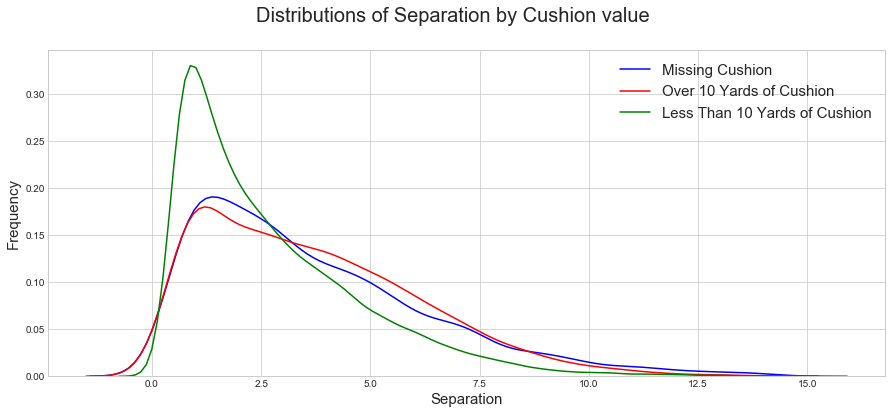

In [26]:
#Create dataframe with just non-Backfield targets
df_1 = df[df['Receiver_Location'] != 'Backfield']

#Separate dataframes into missing and non-missing Dataframes
M = df_1[df_1['Cushion'].isna()]
Over10 = df_1[df_1['Cushion'] >= 10]
Under10 = df_1[df_1['Cushion'] < 10]

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Cushion value', fontsize = 20)

sns.distplot( M['Separation'] , color="blue", label="Missing Cushion", hist = False)
sns.distplot( Over10['Separation'] , color="red", label="Over 10 Yards of Cushion", hist = False)
sns.distplot( Under10['Separation'], color = 'green', label = 'Less Than 10 Yards of Cushion', hist = False)


ax.legend(prop={'size': 15}, )
ax.set_ylabel('Frequency', fontsize = 15)
A = ax.set_xlabel('Separation', fontsize = 15) 

After further inspection, it appears as though **targets with no cushion behave very similarly to targets with 10+ yards of cushion**. Let's do a t-test to see if these two datasets are statistically indiscernable. 

In [27]:
p_value = ks_2samp(M['Separation'], Over10['Separation'])[1]

print('Our p-value for the K-S test to check for 2-sample similarity is ' + str(p_value))
print('Since our p-value > 0.05, it is the case that these two distributions are statistically indiscernable')

Our p-value for the K-S test to check for 2-sample similarity is 1.0
Since our p-value > 0.05, it is the case that these two distributions are statistically indiscernable


## Feature Engineering: Cushion Over 10+ Yards

We have found that not only missing cushion values are statistically significant, but also that when cushion values are greater than 10, the distribution of that variable in relation to the target variable (Separation) behaves like there is a missing cushion value. 

This makes sense intuitively, as the further a defender lines up from a receiver, it is as if there is no one immidiatly defending them. To his end, I will now create another feature called **'missing or 10+ cushion'** that will try to create more insight from the data. 

In [28]:
# Create new column to indicate plater is missing cushion
NB_Features['missing_or_10+_cushion'] = 0
NB_Features['missing_or_10+_cushion'].loc[ (NB_Features['Cushion'].isna()) | (NB_Features['Cushion'] >= 10)] = 1

#How many targets had Missing Cushion OR a Cushion over 10 yards?
NB_Features['missing_or_10+_cushion'].sum()

7688

### Methods of Imputation

1. Replace all missing Cushion values with a summary statistic (mean/median) of Cushion
    - **Pros**: Simple, understandable, and fast
    - **Cons**: Since we are replacing ~10% of our data, this will severely bias our distribution and negatively affect our train/validation accuracies
2. Single Imputation from Regression (kNN, Neural Networks)
    - **Pros**: Introduces less bias than mean/median imputation, is still relatively simple
    - **Cons**: Slower, still does not generate entries that accurately reflect the distribution of the underlying data
3. Multiple Imputation from Chained Equations (MICE)
    - **Pros**: Most accurate, creates multiple imputations and analyzes pool of possible choice to create imputation
    - **Cons**: Slowest and less simple than single imputation
    
    
I am looking to create the most accurate prediction of Separation as I can, so I am choosing **MICE**. 

MICE can be understood as the following steps:
   1. A simple imputation, which in this case, will be the median, is performed for every missing cushion value in the dataset. These median imputations can be thought of as “place holders.”

   2. The “place holder” mean imputations for one variable (“var”) are set back to missing.

   3. The observed values from the variable “var” in Step 2 are regressed on the other variables in the imputation model, which may or may not consist of all of the variables in the dataset. In other words, “var” is the dependent variable in a regression model and all the other variables are independent variables in the regression model.

   4. The missing values for “var” are then replaced with predictions (imputations) from the regression model. When “var” is subsequently used as an independent variable in the regression models for other variables, both the observed and these imputed values will be used.

   5. Steps 2–4 are then repeated for each variable that has missing data. The cycling through each of the variables constitutes one iteration or “cycle.” At the end of one cycle all of the missing values have been replaced with predictions from regressions that reflect the relationships observed in the data.

   6. Steps 2 through 4 are repeated for a number of cycles, with the imputations being updated at each cycle. At the end of these cycles the final imputations are retained, resulting in one imputed dataset. Generally, ten cycles are performed; however, research is needed to identify the optimal number of cycles when imputing data under different conditions. The idea is that by the end of the cycles the distribution of the parameters governing the imputations (e.g., the coefficients in the regression models) should have converged in the sense of becoming stable.

In [29]:
# Transform Categorical Features to One-Hot Encoded Binary Variables

NB_Features_encoded = pd.get_dummies(NB_Features)

NB_Features_encoded.head()


,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,Receiver_Dist_From_Sideline,EZ_Dist,...,Nearest_Def_Position_NT,Nearest_Def_Position_OLB,Nearest_Def_Position_S,Nearest_Def_Position_SAF,Nearest_Def_Position_SS,Nearest_Def_Position_TE,Nearest_Def_Position_WR,Receiver_Location_Slot,Receiver_Location_Tight,Receiver_Location_Wide
0,3,3,9,3.66,24.54,33.119846,1.539,2.084347,26.303329,37.540001,...,0,0,0,0,1,0,0,1,0,0
1,3,1,10,2.66,27.23,37.510450,2.202,1.540033,12.303331,40.230003,...,0,0,0,0,0,0,0,0,0,1
2,3,2,8,10.23,42.88,52.871040,2.633,3.386576,17.230000,58.880001,...,0,0,0,0,0,0,0,0,0,1
3,3,3,8,6.74,39.44,49.233444,3.018,2.814427,19.433328,56.439999,...,0,0,0,0,0,0,0,0,0,1
4,2,1,10,3.23,39.06,46.187710,2.636,1.471224,15.103330,57.060001,...,0,0,0,0,1,0,0,0,0,1


In [30]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

MICE_imputer = IterativeImputer(initial_strategy="median", max_iter = 1000, random_state = random_state)

NB_Features_enc_imp = MICE_imputer.fit_transform(NB_Features_encoded)

Cush_Fill = NB_Features_enc_imp[:,3]
NB_Features['Cushion'] = Cush_Fill

#Check how many null values there are
sum(NB_Features['Cushion'].isna())


0

In [31]:
Merged = NB_Features.copy()
Merged['Separation'] = Target

## Handling Outliers

Looking at the table below, I do not see many outrageous values that would warrant a deeper dive, except for the fact that the 'Air_Time' (time the pass has been launched to pass arrival) column has a minumum value of -0.167. Obviously, time cannot be negative, so I will drop all rows with negative time values. 




In [32]:
Merged.describe()

,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,Receiver_Dist_From_Sideline,EZ_Dist,missing_cushion,missing_or_10+_cushion,Separation
count,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000
mean,2.569796,1.950407,8.850809,6.347717,10.076165,22.743149,1.092692,3.048941,13.078713,38.457193,0.095758,0.175702,2.899077
std,1.125045,0.848593,3.959485,3.207439,9.871677,10.121430,0.570437,1.297303,7.583627,15.301920,0.294263,0.380570,2.231331
min,1.000000,1.000000,1.000000,0.910000,-17.550000,0.555428,-0.167000,0.090554,-5.466669,-3.640000,0.000000,0.000000,0.020000
25%,2.000000,1.000000,6.000000,3.210000,3.700000,15.269947,0.697000,2.150581,6.280000,28.910004,0.000000,0.000000,1.160657
50%,3.000000,2.000000,10.000000,6.290000,7.460000,20.458699,0.902000,2.905056,13.710000,41.430000,0.000000,0.000000,2.278782
75%,4.000000,3.000000,10.000000,8.950000,14.620000,27.795274,1.320000,3.752902,19.243330,50.739998,0.000000,0.000000,4.065145
max,5.000000,4.000000,40.000000,20.900000,63.520000,67.877680,4.586000,13.840437,26.663330,60.000000,1.000000,1.000000,19.226980


In [33]:
Merged = Merged[Merged['Air_Time'] > 0]
print(len(Merged))
print('Looks like we dropped 6 rows with negative Air Time')

43750
Looks like we dropped 6 rows with negative Air Time


In [34]:
#Bring the Time Feature back, it was dropped earlier to create the imputations
Time_Index = Merged.index
Merged['Time'] = df['Time'][Time_Index]
#Merged.head()
Merged.columns

Index(['Nearest_Def_Position', 'Qtr', 'Down', 'To Go', 'Receiver_Location',
       'Cushion', 'Air_Yds', 'Air_Dist', 'Air_Time', 'QB_Separation',
       'Receiver_Dist_From_Sideline', 'EZ_Dist', 'missing_cushion',
       'missing_or_10+_cushion', 'Separation', 'Time'],
      dtype='object')

# Exploratory Data Analysis

Now the fun begins! We are left with 14 Raw Features and 1 Target Variable, as follows:

### Categories of Features
- **Numerical Variables**
    - *Discrete*
        1. Quarter
        2. Down
        3. Yards to Go
    - *Continuous*
        4. Pre-Snap Cushion
        5. Air Yards 
        6. Air Time 
        7. TTT (Time to Throw)
        8. QB Separation
        9. Receiver Distance from Sideline at Target
        10. Distance Receiver is from Back of Endzone
- **Categorical**
    - *Non-Ordinal*
        11. Position of Nearest Defender
        12. Pre-Snap Receiver Location
- **Time Series Data**
    - *DateTime*
        13. Time left in Quarter
        
Lets create a quick correlation heatmap to see how linearly correlated these features are with Receiver Separation:
      

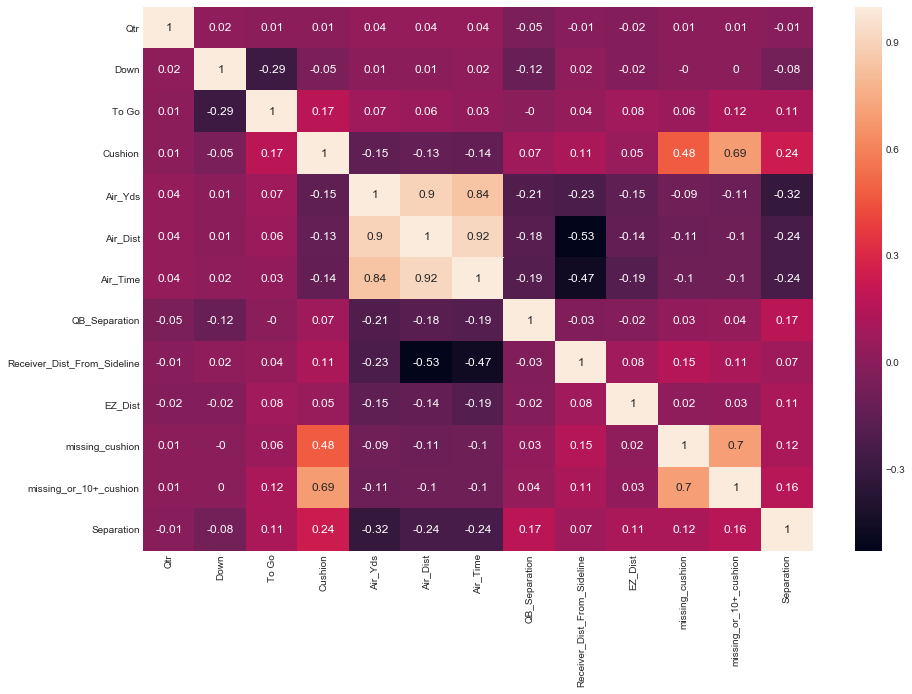

In [35]:
fig =  plt.subplots(figsize=(15,10))
ax = sns.heatmap(round(Merged.corr(method = 'pearson'), 2), annot=True, annot_kws={"size": 12})

## Dropping Collinear Features

Before we move on to dive into each feature, we need to make sure that our features are not collinear. Althought multicollinearity is not inherently bad for the accuracy of predictions, it may affect how the variables are interpreted, which can be detrimental to the intrepretability of the model itself. 

>"The fact that some or all predictor variables are correlated among themselves does not, in general, inhibit our ability to obtain a good fit nor does it tend to affect inferences about mean responses or predictions of new observations.  
>>—Applied Linear Statistical Models, p289, 4th Edition."

Since this model is created for fans, analysts, and GMs, interpretability is of the UTMOST importance. 

The most collinear features are Air Yards, Air Time, and Air Distance. Since Air Yards is most correlated to the target variable (Separation), I will keep it. Air Distance and Air Time have the same correlation to our target variable, so I will look to remove the variable which is most collinear to Air Yards; in this case, this is Air Distance (.90 correlation to Air Yards vs .84). 


## Feature Engineering: Air Speed

In [36]:
#Create new column called 'Air Speed' that is Air Distance over Air Time called 'Air Speed'
Merged['Air_Speed'] = 0
Merged['Air_Speed'] = Merged['Air_Dist']/Merged['Air_Time']
Merged.head()

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,QB_Separation,Receiver_Dist_From_Sideline,EZ_Dist,missing_cushion,missing_or_10+_cushion,Separation,Time,Air_Speed
0,SS,3,3,9,Slot,3.66,24.54,33.119846,1.539,2.084347,26.303329,37.540001,0,0,1.785385,3:15,21.520368
1,CB,3,1,10,Wide,2.66,27.23,37.510450,2.202,1.540033,12.303331,40.230003,0,0,2.674790,10:47,17.034718
2,CB,3,2,8,Wide,10.23,42.88,52.871040,2.633,3.386576,17.230000,58.880001,0,1,3.966674,9:36,20.080152
3,CB,3,3,8,Wide,6.74,39.44,49.233444,3.018,2.814427,19.433328,56.439999,0,0,0.910220,6:45,16.313268
4,SS,2,1,10,Wide,3.23,39.06,46.187710,2.636,1.471224,15.103330,57.060001,0,0,1.676305,3:46,17.521893


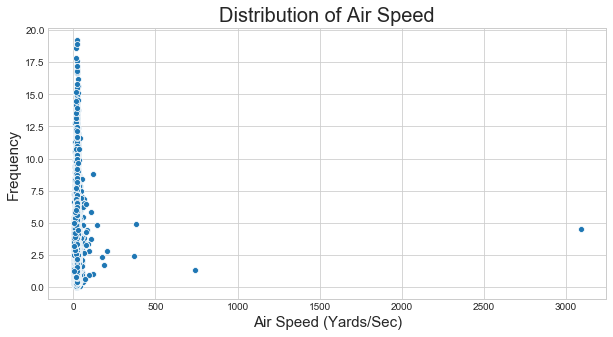

In [37]:
x = Merged['Air_Speed']
y = Merged['Separation']
fig, ax = plt.subplots(figsize=(10, 5))
fig = sns.scatterplot(x=x, y = y)
ax.set_title('Distribution of Air Speed', fontsize = 20)
ax.set_ylabel('Frequency', fontsize = 15)
A = ax.set_xlabel('Air Speed (Yards/Sec)', fontsize = 15)

Yikes! I looks like some of the Air Speed values are unrealistic... 

There's a pass that was said to be thrown over 3000 yards/sec, thats over 6000 MPH! Must've been Josh Allen.

**Possible reasons:**
1. Air Time values near zero
2. Air Distance Values over 1000

Conidering that we just looked at Air Distances, and we saw the max was 67 yards, it must be these miniscule air times that are causing the trouble. 

We saw Patrick Mahomes [throw a pass 62 MPH](https://www.youtube.com/watch?v=HbXhUHIFRkg) last year, so just to be safe, lets say that anything over 70 is unrealistic, and can be removed. 

```70MPH ~ 34.2 yards/second```

In [38]:
A = len(Merged)
Merged = Merged[Merged['Air_Speed'] <= 34.2]
B = len(Merged)
print('We dropped', str(A-B), 'samples')

We dropped 160 samples


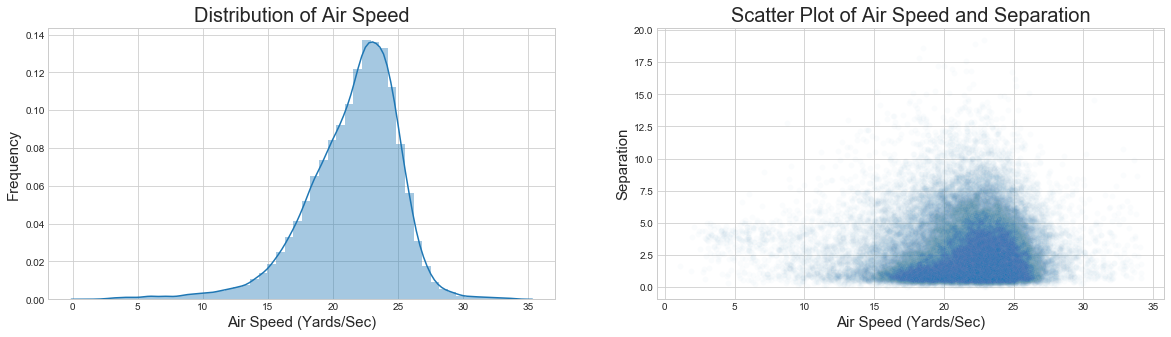

In [39]:
x = Merged['Air_Speed']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Speed', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Speed (Yards/Sec)', fontsize = 15)

ax2.set_title('Scatter Plot of Air Speed and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Air Speed (Yards/Sec)', fontsize = 15)

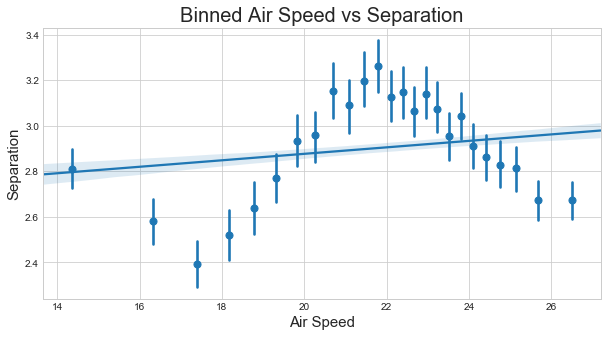

In [40]:
x = Merged['Air_Speed']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 25)

ax.set_title('Binned Air Speed vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Air Speed', fontsize = 15)

In [41]:
x.corr(y, method = 'pearson')

0.023181874636664393

Unfortunately, this does not appear very predictive of separation, but there are feature interactions that can occur in some of the non-linear models that I will test, so we can keep this feature for now. I will drop Air Distance. 

In [42]:
Merged = Merged.drop('Air_Dist', axis = 1)

## Feauture Analysis: Quarter

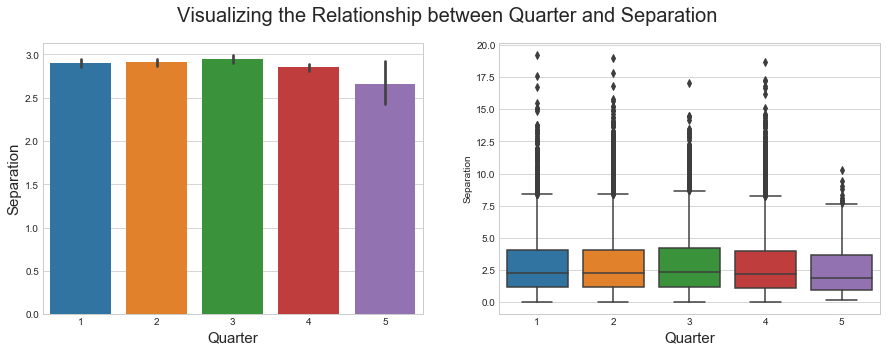

In [43]:
# Show some plots to visualize relationship beteen Quarter and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Quarter and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Qtr', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Qtr', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Quarter', fontsize=15)
ax2.set_xlabel('Quarter', fontsize=15)
A = ax1.set_ylabel('Separation', fontsize=15)

In [44]:
Qtr_df = Merged[['Qtr', 'Separation']]
Qtr_df.groupby(['Qtr']).mean().round({'Separation': 2}).sort_values('Qtr', ascending = True)

,Separation
Qtr,
1,2.90
2,2.91
3,2.95
4,2.85
5,2.66


Just by looking at these distributions, I cannot tell whether quarter has any discernable affect on Separation, especially in the within a regulation game. It looks like passes in Overtime (the 5th quarter, in this case) have the lowest average separation, which makes sense, as the stakes are the highest. That said, before I decide to include/remove the feature, I want to run some t-tests to see if the distributions are statistically different from each other. In other words, is the fact that the average separation for targets in regulation (quarters 1-4) is higher than targets in overtime (quarter 5) significant? Or could this happen with any random subestting of normally distributed data? 

## Feature Engineering - 'Is Overtime' 

I am going to separate all regulation Separations (quarters 1-4) with overtime (quarter 5) to prep my t-test:

Text(0, 0.5, 'Separation')

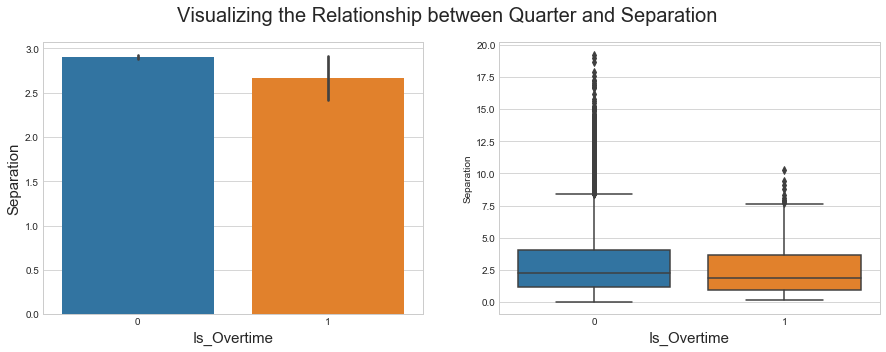

In [45]:
#Create new columns called 'Is_Overtime' that is 1 in overtime and 0 in all other quarter
Merged['Is_Overtime'] = 0
Merged.loc[Merged['Qtr'] == 5, 'Is_Overtime'] = 1

# Show some plots to visualize relationship beteen Quarter and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Quarter and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Is_Overtime', y='Separation', data=Merged, ax = ax1) 
sns.boxplot(x='Is_Overtime', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Is_Overtime', fontsize=15)
ax2.set_xlabel('Is_Overtime', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)


In [46]:
rvs1 = Merged[Merged['Is_Overtime'] == 0]['Separation']
rvs2 = Merged[Merged['Is_Overtime'] == 1]['Separation']

p_value = round(stats.ttest_ind(rvs1,rvs2)[1], 5)

print('Our p value is ' + str(p_value))
print('Since our p value > 0.05, we cannot reject the null hypothesis, making the two disributions statistically similar.')

Our p value is 0.07995
Since our p value > 0.05, we cannot reject the null hypothesis, making the two disributions statistically similar.


Because of this, I will **NOT** include 'Is_Overtime in my modeling/features selection process.

# Feature Analysis: Down

Text(0, 0.5, 'Separation')

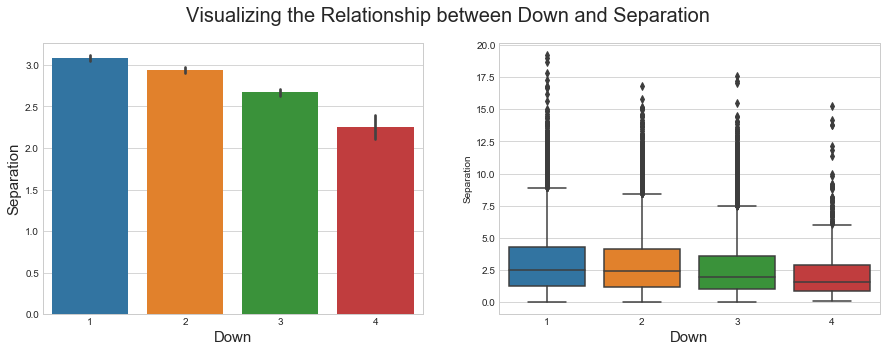

In [47]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Down', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Down', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Down', fontsize=15)
ax2.set_xlabel('Down', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)

In [48]:
Down_df = Merged[['Down', 'Separation']]
Down_df.groupby(['Down']).mean().round({'Separation': 2}).sort_values('Down', ascending = True)

,Separation
Down,
1,3.08
2,2.93
3,2.67
4,2.25


There seems to be a correlation between what down it is and the separation of the targeted receiver. This isn't too surprising, as we would expect defenses to play more tightly in more high-stakes/important downs. 

Nothing more needs to be done here, we will keep Down in the data set and move on.

# Feature Analysis: Yards to Go

Text(0, 0.5, 'Separation')

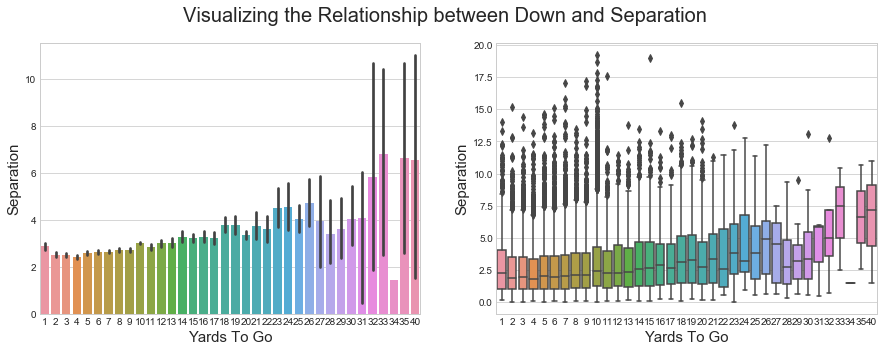

In [49]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='To Go', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='To Go', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Yards To Go', fontsize=15)
ax2.set_xlabel('Yards To Go', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)
ax2.set_ylabel('Separation', fontsize=15)

As we saw above, the correlation coefficient of raw 'Yards To Go' to 'Separation' was 0.11. 

Instead of having 40 unqiue 'To Go' values, I am going to bin certain 'Yards To Go' values into a new category called 'YTG_Bin' or 'Yards To Go Binned.' There will be 4 categories - **Short** (1-4), **Medium** (5-9), **Long** (10), and **Longest** (10+) - in an effort to see if it helps create a higher correlations value or help in predictions. The value of 1 corresponds to Short, and 4 corresponds to Longest.

In [50]:
Merged['YTG_Bin'] = 0

def Create_YTG_Bins(row):
    #Short
    if row <= 4:
        return 'Short'
    
    #Medium
    elif (row >=5 and row <= 9):
        return 'Medium'
    
    #Long
    elif row == 10:
        return 'Long'
    
    #Anything over 10 Yards is Longest!
    elif row > 10:
        return 'Longest'
    
Merged['YTG_Bin'] = Merged['To Go'].apply(Create_YTG_Bins)

In [51]:
YTG_df = Merged.groupby('YTG_Bin').agg(Avg_Sep = ('Separation', 'mean'),Targets = ('Separation', 'size'))
YTG_df = YTG_df.round({'Avg_Sep': 2}).sort_values('Avg_Sep', ascending = False).reset_index()
YTG_df

,YTG_Bin,Avg_Sep,Targets
0,Longest,3.26,6166
1,Long,3.03,19204
2,Medium,2.68,11842
3,Short,2.56,6378


Roughly 44% of all plays in this data set have 10 yards to go, so I split the data as I did in order to try and get as equal a split of plays in each category. 

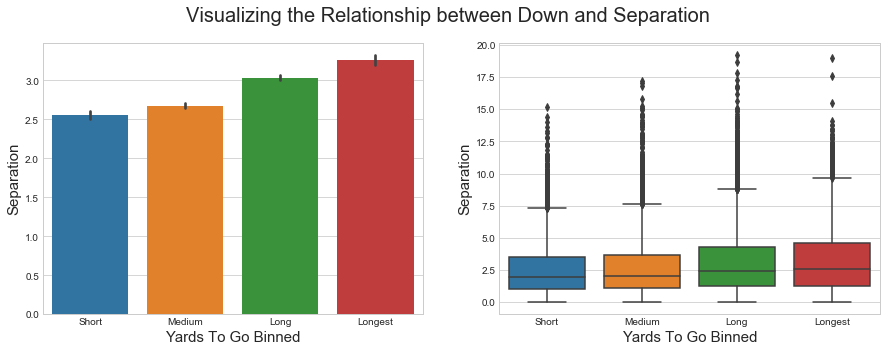

In [52]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

Merged = Merged.sort_values('To Go')

    # Draw the density plots
sns.barplot(x='YTG_Bin', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='YTG_Bin', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Yards To Go Binned', fontsize=15)
ax2.set_xlabel('Yards To Go Binned', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)
A = ax2.set_ylabel('Separation', fontsize=15)

# Feature Engineering: Down & Distance

Now that we have looked at 'Down' and 'Yards to Go' already, I want to combine them to create a 'Down & Distance' feature. Each of these features alone does not seem to have a lot predictive power, but combined, perhaps they will be more helpful. 

In [53]:
Merged['Down_Distance'] = ''
Merged['Down_Distance'] = Merged['Down'].astype(str) + '&' + Merged['YTG_Bin']

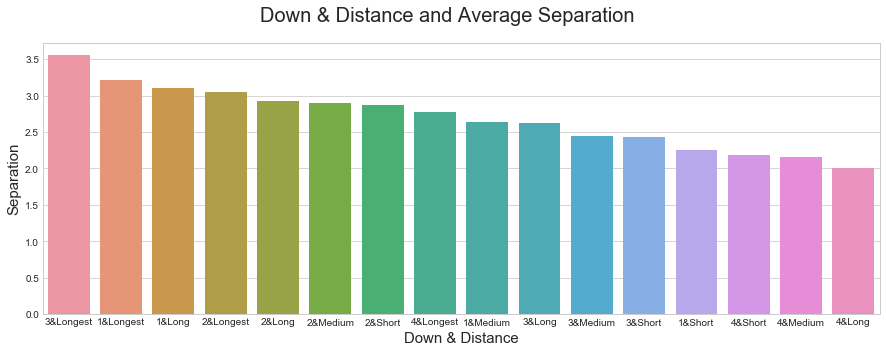

In [54]:
D_D_df = Merged[['Down_Distance', 'Separation']]
dddf = D_D_df.groupby(['Down_Distance']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False).reset_index()
dddf['Play_Counts'] = D_D_df.groupby(['Down_Distance']).count().round({'Separation': 2}).sort_values('Separation', ascending = False)

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Down & Distance and Average Separation', fontsize=20)
sns.barplot(x='Down_Distance', y = 'Separation', data = dddf)

ax.set_xlabel('Down & Distance', fontsize=15)
A = ax.set_ylabel('Separation', fontsize=15)


# Feature Analysis: Cushion

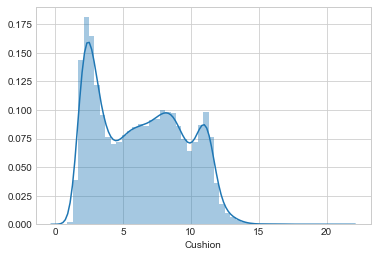

In [55]:
fig = sns.distplot(Merged['Cushion'])

I am noticing the **Trimodal** nature of this distribution, suggesting that defenders usually either line up close to the receiver (think Press coverage), somewhere 4-10 yards off, or very far off of them (or 'Off' coverage). From this, I want to further look into how these three types of cushion relate to the recievers separation

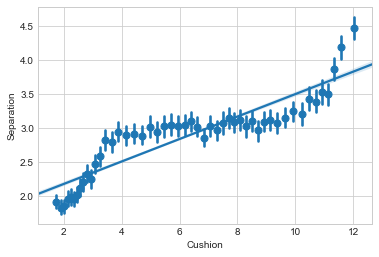

In [56]:
y = Merged['Separation']
x = Merged['Cushion']
p1 = sns.regplot(x=x, y=y, data=Merged, x_bins = 50)

# Feature Engineering: Press, Regular, & Off Coverage

Seen in the binned scatter plot above, we can see that, on the whole, an increase in cushion leads (or at least is linearly correlated to) an increase in separation, up until about 3 yards of cushion. I will create a new feature called 'Press_Cushion' that is equal to 1 when they are 'pressed' at the line of scrimmage (< 3 yards) 0 when lining up 3-10 yards away, and set to 2 when 10+ yards away.

In [57]:
Merged['Cushion_Type'] = 1
Merged['Cushion_Type'].loc[Merged['Cushion'] <= 3] = 0
Merged['Cushion_Type'].loc[Merged['Cushion'] >= 10] = 2
Merged.head() 

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Time,QB_Separation,Receiver_Dist_From_Sideline,EZ_Dist,missing_cushion,missing_or_10+_cushion,Separation,Time,Air_Speed,Is_Overtime,YTG_Bin,Down_Distance,Cushion_Type
39116,CB,4,2,1,Wide,7.84,28.50,1.426,1.710819,5.95,15.500000,0,0,5.033577,6:26,24.881529,0,Short,2&Short,1
32132,CB,1,2,1,Slot,8.34,-2.87,0.540,5.556663,9.14,44.129997,0,0,4.430282,14:34,26.120144,0,Short,2&Short,1
51076,CB,2,3,1,Tight,5.36,0.04,0.708,4.118070,14.14,44.040001,0,0,2.877030,2:23,20.966966,0,Short,3&Short,1
51077,FS,2,4,1,Wide,3.96,5.48,1.168,2.434030,4.71,49.480003,0,0,2.489659,2:00,19.524922,0,Short,4&Short,1
26653,CB,3,4,1,Wide,7.23,3.76,0.834,2.918938,5.29,49.240002,0,0,2.992558,11:56,25.257755,0,Short,4&Short,1


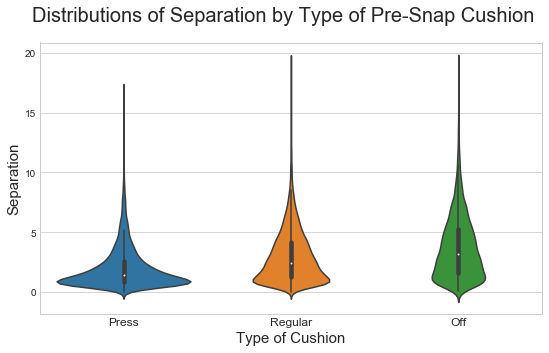

In [58]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig = plt.figure(figsize=(9,5))

sns.violinplot(x="Cushion_Type", y="Separation", data=Merged)

plt.suptitle('Distributions of Separation by Type of Pre-Snap Cushion', fontsize = 20)
plt.ylabel('Separation', fontsize = 15)
plt.xlabel('Type of Cushion', fontsize = 15)

A = plt.xticks([0, 1, 2], ['Press', 'Regular', 'Off'], fontsize = 12)

In [59]:
Pressed = Merged[['Cushion_Type', 'Separation']]
mapping = {2: 'Off', 1: 'Regular', 0:  'Press'}
Pressed['Cushion_Type'] = Pressed['Cushion_Type'].map(mapping) 
Pressed.groupby(['Cushion_Type']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)

,Separation
Cushion_Type,
Off,3.72
Regular,2.99
Press,2.03


Players who were pressed at the line of scrimmage (less than 3 yards of pre-snap cushion) saw **more than a yard of separation less** at pass arrival than receivers who were not pressed. 

To confirm, look at the overlaid distributions below to see how receivers who are pressed perform differently to those who are not pressed.

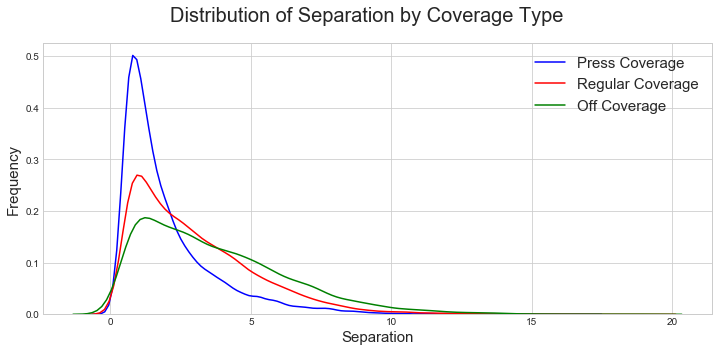

In [60]:
# List of two types of data to plot
Coverage_Types = ['Press Coverage', 'Regular Coverge', 'Off Coverage']

fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distribution of Separation by Coverage Type', fontsize = 20)

sns.distplot( Merged['Separation'].loc[Merged['Cushion_Type'] == 0] , color="blue", label="Press Coverage", hist = False)
sns.distplot( Merged['Separation'].loc[Merged['Cushion_Type'] == 1] , color="red", label="Regular Coverage", hist = False)
sns.distplot( Merged['Separation'].loc[Merged['Cushion_Type'] == 2], color = 'green', label = 'Off Coverage', hist = False)
    
# Draw the density plots
ax.legend(loc=1, prop={'size': 15})
ax.set_ylabel('Frequency', fontsize = 15)
A = ax.set_xlabel('Separation', fontsize = 15)

# Feature Analysis: Air Distance

**Air Distance** - the straight line distance from where the ball is thrown to the where the ball is either caught, or the location of the targeted receiver (as the crow flies). 

In [61]:
# x = Merged['Air_Dist']
# y = Merged['Separation']

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


# sns.distplot(x, ax = ax1)
# sns.scatterplot(x=x, y = y, alpha = 0.02)

# ax1.set_title('Distribution of Air Distance', fontsize = 20)
# ax1.set_ylabel('Frequency', fontsize = 15)
# ax1.set_xlabel('Air Distance', fontsize = 15)

# ax2.set_title('Scatter Plot of Air Distance and Separation', fontsize = 20)
# ax2.set_ylabel('Separation', fontsize = 15)
# ax2.set_xlabel('Air Distance', fontsize = 15)

In [62]:
# x = Merged['Air_Dist']
# y = Merged['Separation']

# fig, ax = plt.subplots(figsize = (10,5))
# sns.regplot(x=x, y = y, x_bins = 15)

# ax.set_title('Binned Air Distance vs Separation', fontsize = 20)
# ax.set_ylabel('Separation', fontsize = 15)
# A = ax.set_xlabel('Air Distance', fontsize = 15)

In [63]:
# #What is the correlation between Air Distance and Separation?
# x.corr(y, method = 'pearson')

# Feature Analysis: Air Yards

**Air Yards** - the distance a pass is from the line of scrimmage, and can be negative if the pass is thrown to a reciever behind the line of scrimmage

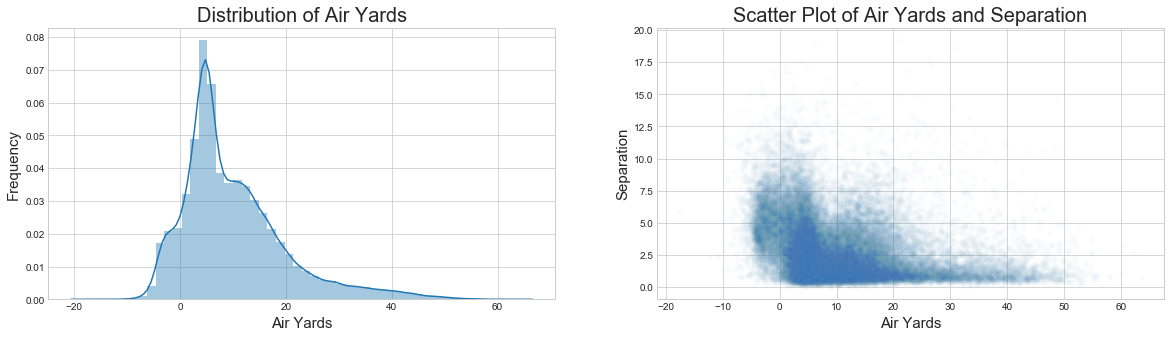

In [64]:
x = Merged['Air_Yds']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Yards', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Yards', fontsize = 15)

ax2.set_title('Scatter Plot of Air Yards and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Air Yards', fontsize = 15)

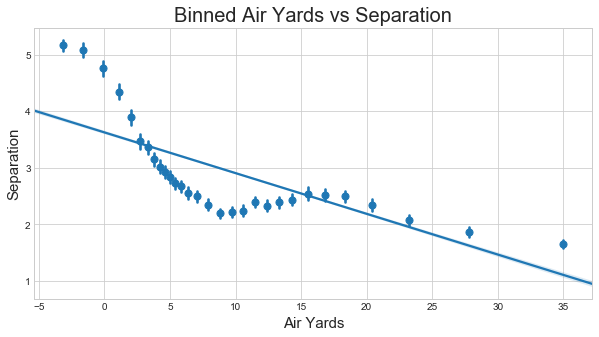

In [65]:
x = Merged['Air_Yds']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('Binned Air Yards vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Air Yards', fontsize = 15)

# Feature Analysis: Air Time

**Air Time** - the the time from the ball is released for the pass to the time the pass arrives to the targeted receiver. 

Text(0.5, 0, 'Air Time')

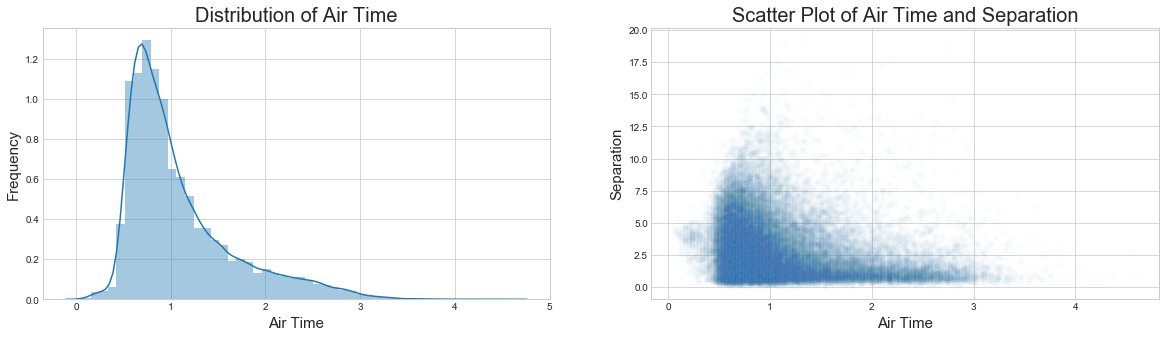

In [66]:
x = Merged['Air_Time']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Time', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Time', fontsize = 15)

ax2.set_title('Scatter Plot of Air Time and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
ax2.set_xlabel('Air Time', fontsize = 15)

In [67]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Air Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Air Time and Separation')

Spearman (rank) correlation: -0.274 between Air Time and Separation
Pearson (linear) correlation: -0.238 between Air Time and Separation


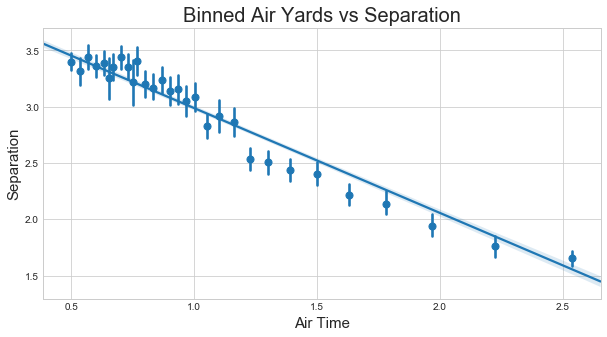

In [68]:
x = Merged['Air_Time']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('Binned Air Yards vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Air Time', fontsize = 15)

# Feature Analysis: QB Separation

**QB Separation** - The distance between the QB and the nearest defender (usually a pass rusher) to the QB at the time the pass in thrown.

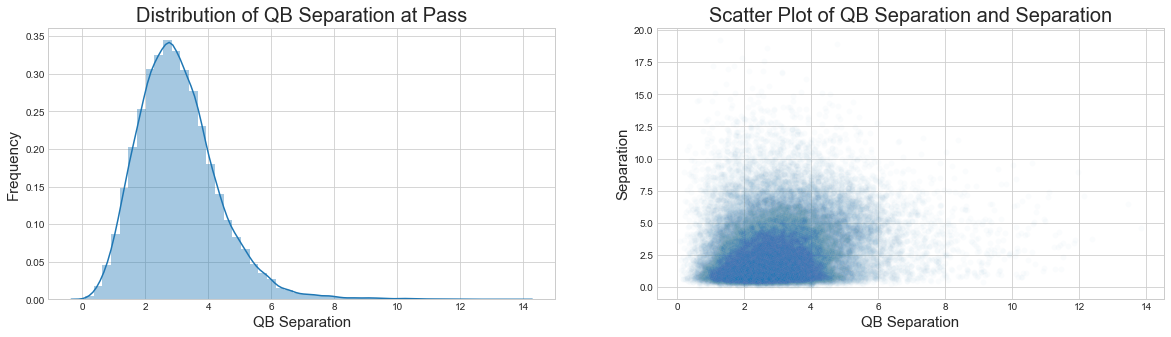

In [69]:
x = Merged['QB_Separation']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of QB Separation at Pass', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('QB Separation', fontsize = 15)

ax2.set_title('Scatter Plot of QB Separation and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('QB Separation', fontsize = 15)

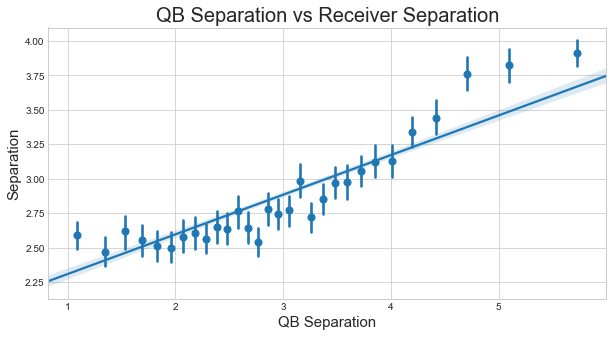

In [70]:
x = Merged['QB_Separation']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('QB Separation vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('QB Separation', fontsize = 15)

# Feature Analysis: Receiver Distance from Sideline as Pass Arrival

This feature quantifies the distance (in yards) from the targeted receiver and the nearest sideline at the time pass arrives. 

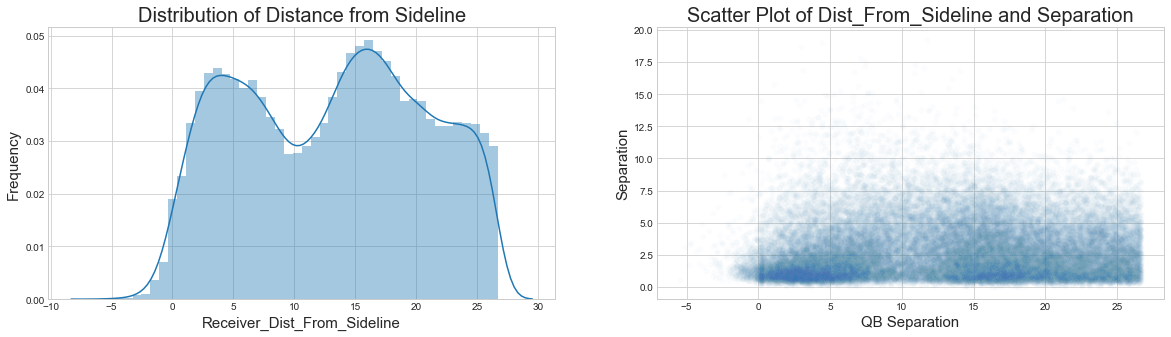

In [71]:
x = Merged['Receiver_Dist_From_Sideline']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Distance from Sideline', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Receiver_Dist_From_Sideline', fontsize = 15)

ax2.set_title('Scatter Plot of Dist_From_Sideline and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('QB Separation', fontsize = 15)

In the graph above, we see the distribution is **bimodal**, with values no greater than 26.66 (exactly at midfield) and going into the negatives. Negative values here indicate that the receiver was out of bounds by the time the pass arrived. 

In [72]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Sideline Distance and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Sideline Distance and Separation')

Spearman (rank) correlation: 0.101 between Sideline Distance and Separation
Pearson (linear) correlation: 0.068 between Sideline Distance and Separation


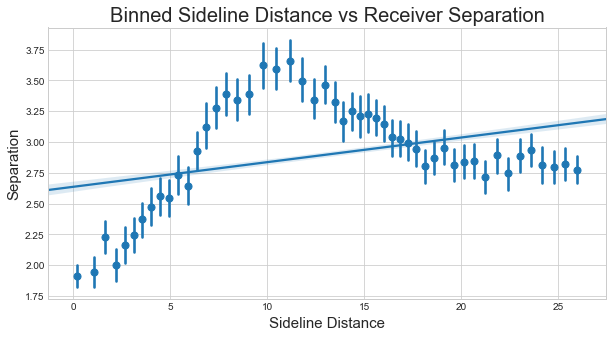

In [73]:
x = Merged['Receiver_Dist_From_Sideline']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 50)

ax.set_title('Binned Sideline Distance vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Sideline Distance', fontsize = 15)

Average Separation decreases steadily once the receiver gets 10 yards away from the sideline. 

I am going to create a new feature, called 'is_near_sideline' that is equal to 0 when a receiver is more than 5 yards from the sideline at target, and equal to the sideline distance when the player is within 5 yards of the sideline to try and distinguish these types of situations.

# Feature Engineering: 'is_near_sideline'

In [74]:
Merged['is_near_sideline'] = 0
Merged['is_near_sideline'].loc[Merged['Receiver_Dist_From_Sideline'] <= 5] = 1
A = np.count_nonzero(Merged['is_near_sideline'])
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets were within 5 yards of the sideline, or ' + str(C) + '% of all plays')

8638 of 43590 targets were within 5 yards of the sideline, or 19.8% of all plays


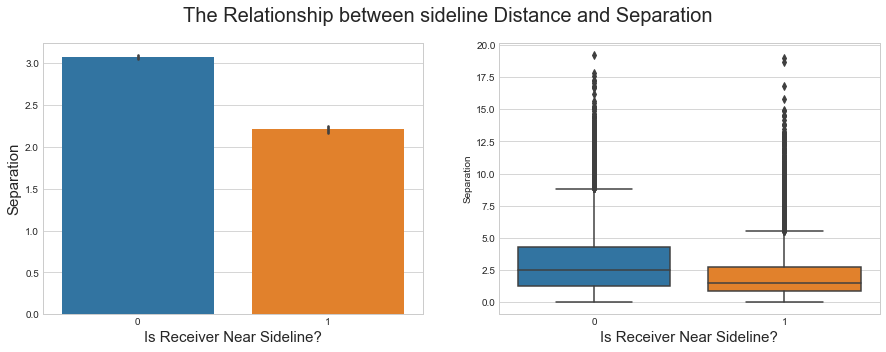

In [75]:
# Show some plots to visualize relationship between Sideline Distance and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('The Relationship between sideline Distance and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='is_near_sideline', y='Separation', data=Merged, ax = ax1) 
sns.boxplot(x='is_near_sideline', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Is Receiver Near Sideline?', fontsize=15)
ax2.set_xlabel('Is Receiver Near Sideline?', fontsize=15)
A = ax1.set_ylabel('Separation', fontsize=15)

# Feature Analysis: Distance Receiver is from Back of Endzone

This feature is defined as the distance (in yards) that there recevier is from the back of the endzone (in the direction the play is facing). 

My initial thought is that this feature will be noise until the receiver gets within some yardage from the back of the endzone, and then get lower as it endzone distance goes to 0. 

For refence, EZ_distance does not get higher than 60 because it is not tracked until a receier crosses midfield (which is 60 yards from back of endzone)

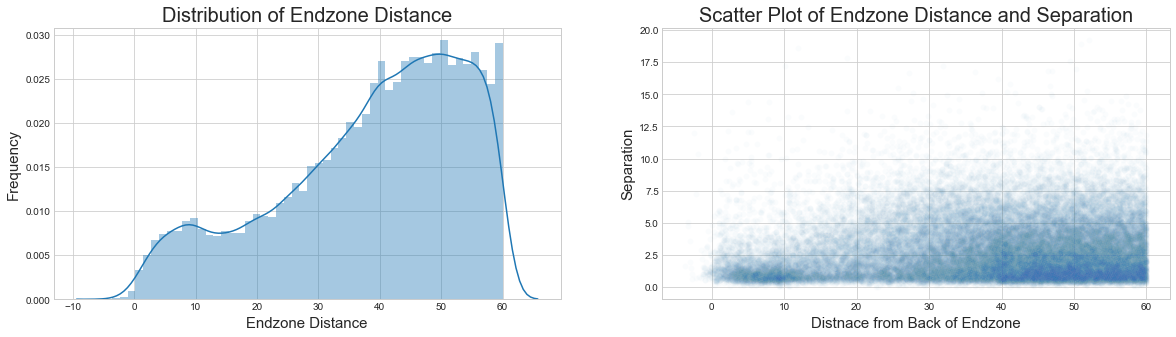

In [76]:
x = Merged['EZ_Dist']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Endzone Distance', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Endzone Distance', fontsize = 15)

ax2.set_title('Scatter Plot of Endzone Distance and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Distnace from Back of Endzone', fontsize = 15)

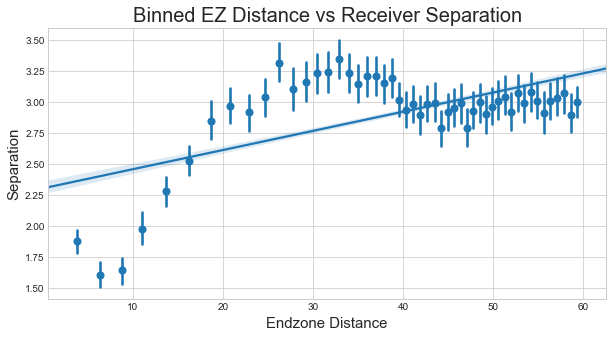

In [77]:
x = Merged['EZ_Dist']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 50)

ax.set_title('Binned EZ Distance vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Endzone Distance', fontsize = 15)

# Feature Engineering: Receiver Within 5 yard line?

Create binary value that is 1 when the target receiver is within 5 yards of the goalline (or 15 yards from the back of the endzone) and 0 everywhere else.

In [78]:
Merged['is_within_5'] = 0
Merged['is_within_5'].loc[Merged['EZ_Dist'] <= 15] = 1
A = Merged['is_within_5'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets were within 5 yards of the goal line, or ' + str(C) + '% of all plays')

4718 of 43590 targets were within 5 yards of the goal line, or 10.8% of all plays


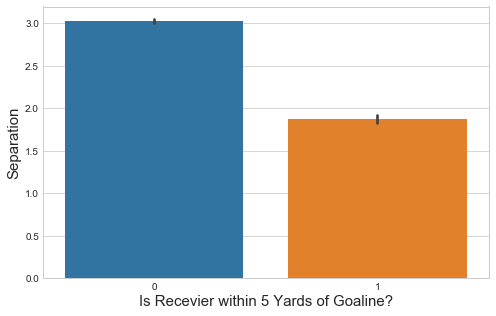

In [79]:
x = Merged['is_within_5']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Is Recevier within 5 Yards of Goaline?', fontsize = 15)

Receivers are allowed _more than yard more_ of separation when they are **NOT** within 5 yards of the goalline (15 yards from the back of the endzone)

# Categorical Features

## Position of Nearest Defender

In [80]:
Pos_df = Merged[['Nearest_Def_Position', 'Separation']]
Position = Pos_df.groupby(['Nearest_Def_Position']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)
Position['Play_Counts'] = Pos_df.groupby(['Nearest_Def_Position']).count()
Position

,Separation,Play_Counts
Nearest_Def_Position,,
DE,5.14,873
NT,5.13,115
DT,5.02,624
DL,4.50,17
OLB,3.69,3315
LB,3.65,1506
MLB,3.36,1512
ILB,3.34,2596
WR,3.01,18


It looks there are a lot of different positions listed here, but 20K plays belong just to CBs. I don't think there is much difference between positions like OLB and ILB, as well as DL vs DE vs DT. To this end, I will consolidate these categories to make it simpler to understand. Also, it looks like a few offensive skill players have been used on defense occasionally. Since they represent ~20 rows, I am going to drop them.

In [81]:
# Dropping all rows where skill position players that were the ones who were the nearest defender at pass arrival
skillpos = ['WR', 'TE', 'FB', 'RB', 'QB']
Merged = Merged[~Merged['Nearest_Def_Position'].isin(skillpos)]

## Feature Engineering: Clean up Defender Position Categories

In [82]:
LB = ['OLB', 'ILB', 'MLB', 'LB']
DL = ['DL', 'DE', 'DT', 'NT']
CB = ['CB', 'DB']
SAFE = ['SAF', 'S', 'FS', 'SS']

def NearestPos(row):
    
    #LBs
    if row in LB:
        return 'LB'
    
    #DLs
    elif row in DL:
        return 'DL'
    
    #CBs
    elif row in CB:
        return 'CB'
    
    #Safeties
    elif row in SAFE:
        return 'STY'
    else:
        return 'Other'
    

Merged['NDP'] = ''
Merged['NDP'] = Merged['Nearest_Def_Position'].copy().apply(NearestPos)    

In [83]:
NDP_df = Merged[['NDP', 'Separation']]
Pos = NDP_df.groupby(['NDP']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)
Pos['Play_Counts'] = NDP_df.groupby(['NDP']).count()
Pos

,Separation,Play_Counts
NDP,,
DL,5.09,1629
LB,3.53,8929
STY,2.90,8182
CB,2.53,24829


# Feature: Pre-Snap Receiver Location

This is what we covered a bit in earlier analysis, but this is broken down into 3 (previously 4, before _backfield_ was removed) categories:
- Wide
- Slot
- Tight

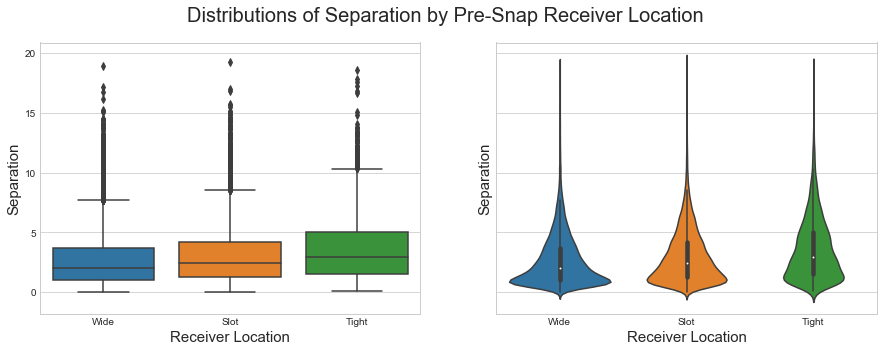

In [84]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))


sns.boxplot(x="Receiver_Location", y="Separation", data=Merged, ax = ax1)
sns.violinplot(x="Receiver_Location", y="Separation", data=Merged, ax = ax2)

fig.suptitle('Distributions of Separation by Pre-Snap Receiver Location', fontsize = 20)
ax1.set_ylabel('Separation', fontsize = 15)
ax1.set_xlabel('Receiver Location', fontsize = 15)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Receiver Location', fontsize = 15)

There are marginal differences between the distributions of these three locations, and I am going to leave them as-is. 

# Feature Analysis: Time

There are 60 minutes in an NFL football game, and I don't think there is any inherent difference that we should expect when it comes to separation when its the start of the 1st, 2nd, 3rd, or 4th quarter. I think there might be more interesting things to find, but I want to translate this MM:SS time string that I am given to an integer value of seconds left in game, and go from there.

In [85]:
def time_to_seconds(time_str):
    #Change the string 'Time' to a value in seconds
    
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

#Quick check to make sure this function does what I am intending
print(str(Merged['Time'][3]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][3])) + ' seconds')
print(str(Merged['Time'][50]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][50])) + ' seconds')
print(str(Merged['Time'][302]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][302])) + ' seconds')

6:45 is equal to 405 seconds
10:29 is equal to 629 seconds
13:46 is equal to 826 seconds


I found a bug with the function, because it didn't know how to treat 'nan' Time values. These were not found earlier because they are 'non as strings, not the Nans that pandas recognizes. Let's remove them now

In [86]:
Merged['Time'] = Merged['Time'].astype(str)
Merged = Merged[Merged['Time'] != 'nan']

In [87]:
Merged['Time_in_Sec'] = Merged['Time'].apply(time_to_seconds)

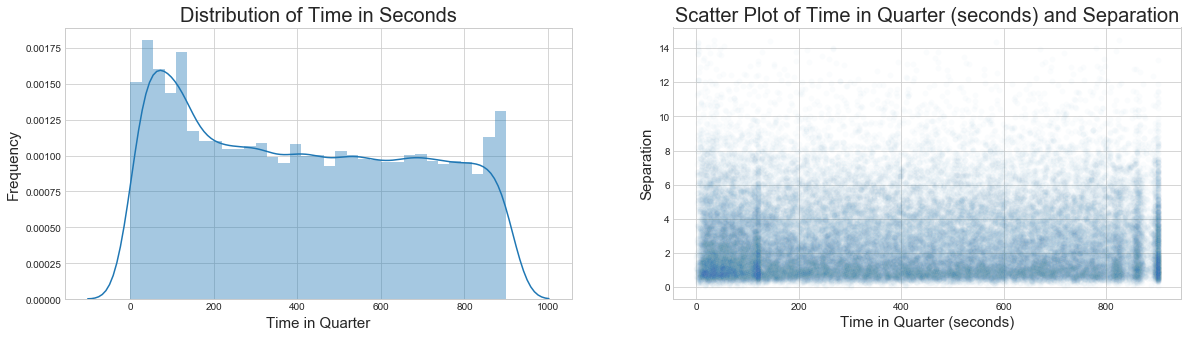

In [88]:
x = Merged['Time_in_Sec']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Time in Seconds', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Time in Quarter', fontsize = 15)

ax2.set_title('Scatter Plot of Time in Quarter (seconds) and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Time in Quarter (seconds)', fontsize = 15)

In [89]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time and Separation')

Spearman (rank) correlation: 0.021 between Time and Separation
Pearson (linear) correlation: 0.015 between Time and Separation


As you might've guessed, the time left in a quarter has almost no correlation to the separation. 

Let's do some feature engineering to see if we can get some more insight out of this feature.

# Feature Engineering: Time Left in Game/Time Left in Half

Its not enough to use just the time left in the quarter to understand how time left affects gameplay, especially receiver separation. Let's see if include Quarter into this measurement helps us understand more.

In [90]:
Merged['sec_left_in_game'] = Merged['Time_in_Sec'] + ((4-Merged['Qtr'])*15*60)


#Check to see that this is doing what we are expecting

print(str(Merged['Time'][3]) + ' in the ' + str(Merged['Qtr'][3]) + 'rd Quarter is equal to ' + str(Merged['sec_left_in_game'][3]) + ' seconds')
print(str(Merged['Time'][30]) + ' in the ' + str(Merged['Qtr'][30]) + 'th Quarter is equal to ' + str(Merged['sec_left_in_game'][30]) + ' seconds')
print(str(Merged['Time'][302]) + ' in the ' + str(Merged['Qtr'][302]) + 'st Quarter is equal to ' + str(Merged['sec_left_in_game'][302]) + ' seconds')

6:45 in the 3rd Quarter is equal to 1305 seconds
7:24 in the 4th Quarter is equal to 444 seconds
13:46 in the 3st Quarter is equal to 1726 seconds


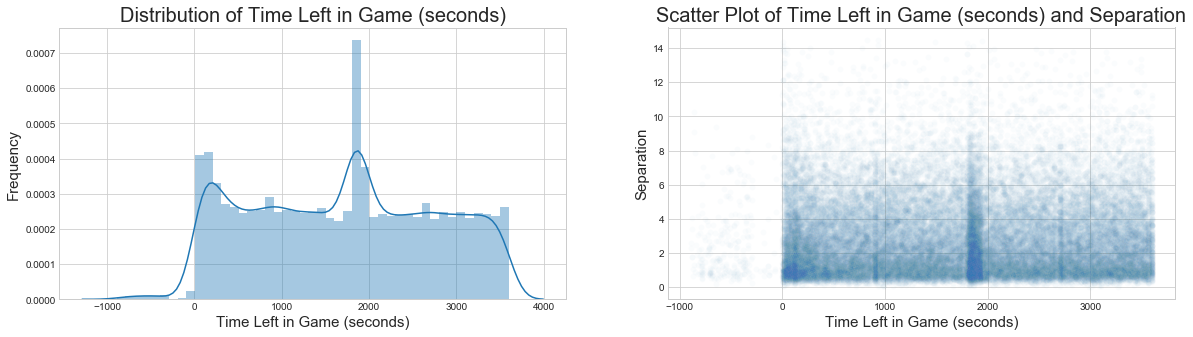

In [91]:
x = Merged['sec_left_in_game']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Time Left in Game (seconds)', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Time Left in Game (seconds)', fontsize = 15)

ax2.set_title('Scatter Plot of Time Left in Game (seconds) and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Time Left in Game (seconds)', fontsize = 15)

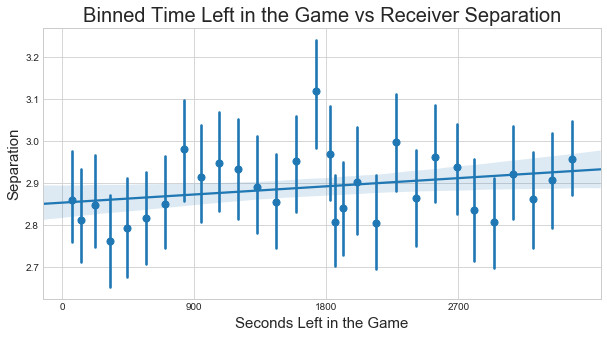

In [92]:
x = Merged['sec_left_in_game']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('Binned Time Left in the Game vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
plt.xticks(np.arange(0, 3600, step=900))
A = ax.set_xlabel('Seconds Left in the Game', fontsize = 15)

I cannot see any strong trends from the graph above, so let me take this a step further, by isolating time by halves.

## Feature Engineering: Time Left in Half

I would like to see if theres anything to the fact that 2 minute scenarios (ends of each half) might be more telling. I suspect that creating a new field called **_'time left in half'_** might be more insightful

In [93]:
mask = (Merged['Qtr'] == 1) | (Merged['Qtr'] == 3)
Merged['sec_left_in_half'] = Merged['Time_in_Sec']
Merged['sec_left_in_half'][mask] = Merged['Time_in_Sec'] + 900
Merged.head() 

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Time,QB_Separation,Receiver_Dist_From_Sideline,...,Is_Overtime,YTG_Bin,Down_Distance,Cushion_Type,is_near_sideline,is_within_5,NDP,Time_in_Sec,sec_left_in_game,sec_left_in_half
39116,CB,4,2,1,Wide,7.84,28.50,1.426,1.710819,5.95,...,0,Short,2&Short,1,0,0,CB,386,386,386
32132,CB,1,2,1,Slot,8.34,-2.87,0.540,5.556663,9.14,...,0,Short,2&Short,1,0,0,CB,874,3574,1774
51076,CB,2,3,1,Tight,5.36,0.04,0.708,4.118070,14.14,...,0,Short,3&Short,1,0,0,CB,143,1943,143
51077,FS,2,4,1,Wide,3.96,5.48,1.168,2.434030,4.71,...,0,Short,4&Short,1,1,0,STY,120,1920,120
26653,CB,3,4,1,Wide,7.23,3.76,0.834,2.918938,5.29,...,0,Short,4&Short,1,0,0,CB,716,1616,1616


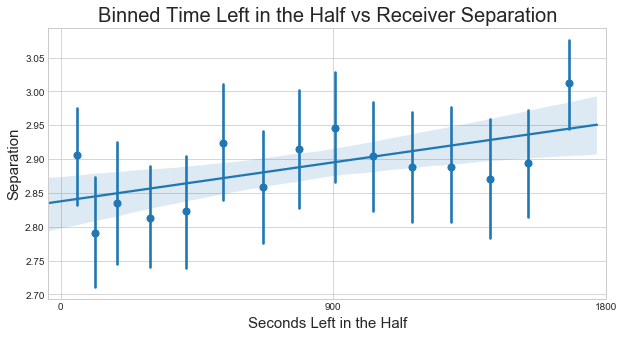

In [94]:
x = Merged['sec_left_in_half']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y,  x_bins = 15)

ax.set_title('Binned Time Left in the Half vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
plt.xticks(np.arange(0, 2700, step=900))
A = ax.set_xlabel('Seconds Left in the Half', fontsize = 15)

In [95]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time and Separation')

Spearman (rank) correlation: 0.024 between Time and Separation
Pearson (linear) correlation: 0.016 between Time and Separation


Turns out, this had little to **no effect** on my correlation values, but so it goes! I am going to try one more thing to see if it is potentially helpful. I am going to create a boolean for 'is_under_2_min' that checks whether the play comes with under 2 minuets left in the half.

## Feature Engineering: 2-Minute Drill? 

Does the pass come with under 2 minutes left in a half?

In [96]:
Merged['Under_2Min'] = 0
Merged['Under_2Min'].loc[Merged['sec_left_in_half'] <= 120] = 1

A = Merged['Under_2Min'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets came with under 2 min remaining in the half, or ' + str(C) + '% of all plays')

6282 of 43539 targets came with under 2 min remaining in the half, or 14.4% of all plays


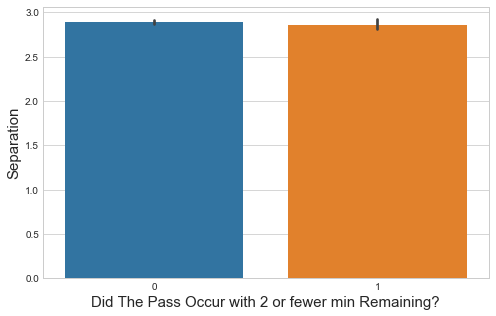

In [97]:
x = Merged['Under_2Min']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Did The Pass Occur with 2 or fewer min Remaining?', fontsize = 15)

Even after doing this work, unfortunately, **being under 2 min left in the half has almost no correlation** to receiver separation. 

# Feature Selection

We started with 16 raw feaures in the dataset, and we engineered 14 more features with the prosect of trying to create more insightful variables. Now with 30 features to sift through, let's dive in to the process of selecting the features that account for the most variance in the output variable (*Receiver Separation*)

I would like to note that it would be perfectly fine to use all 30 features and see how it all turns out, but when potentially dealing with linear regression modeling we should be wary that including unessary, co-variate, or redundant features would only cloud our predictions.

> _Many models, especially those based on regression slopes and intercepts, will estimate parameters for every term in the model. Because of this, the presence of non-informative variables can add uncertainty to the predictions and reduce the overall effectiveness of the model._
>
> Page 488, Applied Predictive Modeling, 2013.

In [98]:
#Time is a string, we don't need it now that we have it in seconds, let's drop it

Merged = Merged.drop('Time', axis = 1)
Merged = Merged.drop('Time_in_Sec', axis = 1)
Merged = Merged.drop('Nearest_Def_Position', axis = 1)

In [99]:
#Check to see how many null values there are left
Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43539 entries, 39116 to 17558
Data columns (total 24 columns):
Qtr                            43539 non-null int64
Down                           43539 non-null int64
To Go                          43539 non-null int64
Receiver_Location              43539 non-null object
Cushion                        43539 non-null float64
Air_Yds                        43539 non-null float64
Air_Time                       43539 non-null float64
QB_Separation                  43539 non-null float64
Receiver_Dist_From_Sideline    43539 non-null float64
EZ_Dist                        43539 non-null float64
missing_cushion                43539 non-null int64
missing_or_10+_cushion         43539 non-null int64
Separation                     43539 non-null float64
Air_Speed                      43539 non-null float64
Is_Overtime                    43539 non-null int64
YTG_Bin                        43539 non-null object
Down_Distance                  43539 

### Handling Skewed Features/Log/Cube Root Transform

For linear models, an assumption that we make is that the features we select have a linear relationshup to the target variable. (Separation). Unfortunately, a lot of the features in my dataset do not relate to separation linearly. So, to encourage this behavior, we will apply a log transform to the skewed features, so that they behave more linearly in relation to out target variable. 

In fact, we will be using the log1p() NumPy funciton which adds 1 to every element of the feature before taking the log of it so that there are no errors at 0. Also, I noticed after trying to fit this model to a basic linear regression that the residuals were not normally distributed and that the I was often overpredicting separation. In response, I will apply a **cube root transformation** to account for this non-gaussian behavior. I chose a cube root transform for Separation specifically because it performed better at creating a more normal distribution than the log transform. 

In [100]:
#Make a copy of the dataframe
Merged_T = Merged.copy()

#log transform skewed numeric floating point (continuous) features:
float_cols = Merged_T.drop('Separation', axis =1).select_dtypes(include=['float64'])
float_cols = float_cols.columns

skewed_feats = Merged_T[float_cols].apply(lambda x: stats.skew(x)) #compute skewness
skewed_feats = skewed_feats[skewed_feats > .50]
skewed_feats = skewed_feats.index

print('There are ' + str(len(skewed_feats)) + ' skewed features that needed to be log transformed')
print('The Skewed features were ' + str(list(skewed_feats)))

# Air Yards needs to be shifted before we log transform

Merged_T['Air_Yds'] = Merged_T['Air_Yds'] + 20

#Apply log(1+x) transform to all feaures with skewed distributions

Merged_Trans = Merged_T.copy()
Merged_Trans[skewed_feats] = np.log1p(Merged_Trans[skewed_feats])

There are 3 skewed features that needed to be log transformed
The Skewed features were ['Air_Yds', 'Air_Time', 'QB_Separation']


In [101]:
Merged_Trans[skewed_feats].describe()

,Air_Yds,Air_Time,QB_Separation
count,43539.000000,43539.000000,43539.000000
mean,3.392162,0.707911,1.349664
std,0.292764,0.242860,0.316020
min,1.238374,0.063913,0.086686
25%,3.207208,0.530628,1.148468
50%,3.348851,0.645007,1.362671
75%,3.573188,0.841783,1.559126
max,4.436988,1.720263,2.697356


In [102]:
float_cols

Index(['Cushion', 'Air_Yds', 'Air_Time', 'QB_Separation',
       'Receiver_Dist_From_Sideline', 'EZ_Dist', 'Air_Speed'],
      dtype='object')

## Encoding Categorical Variables

Before we can start doing any worthwhile analysis, we have to encode our categorical variables into numerical ones so our linear/ML models can begin to understand what they represent. To do this, we will **1-HOT ENCODE** all our categorical variables, creating a new column for each possible value within each category. This isnt necessarily the most effective or accurate way to encode our variables, but it is tried and true, and creates a good baseline. If we want to ensure no stone is unturn later, we can revisit other ways to encode each categorical variable.

In [103]:
# One Hot Encodes all labels before Machine Learning

Merged_Enc = pd.get_dummies(data = Merged_Trans)
print('We have', len(Merged_Enc.columns), 'features to help with predictions')

We have 47 features to help with predictions


## Train/Test Split

Before we start our analysis, we must split our data into a Training set, a Test set, and a Validation Set. We do this so that during our model fitting process, we do no overfit to the trainging set, which would cause our model to become less accurate when generalizing to new data. 

In [104]:
from sklearn.model_selection import train_test_split

# Split data into 70% Training, 20% Test data, 10% Validation data
# We won't touch the Test data until after we have chosen our features and modeled/fit our training set with our validation set

X = Merged_Enc.copy().drop('Separation', axis=1)
y = Merged_Enc.copy()['Separation']


#Split data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state) 

#Split Train Data into Train_2 and Validation
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state = random_state)


#How big are the data sets?
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_2.shape, X_val.shape, y_train_2.shape, y_val.shape

((34831, 46),
 (8708, 46),
 (34831,),
 (8708,),
 (30477, 46),
 (4354, 46),
 (30477,),
 (4354,))

<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' alt="Drawing" style="width: 450px;"/>

## Model Evaluation Prodecedure

The evaluation process for seeing how accurate my predictions are will be based on **MEAN ABSOLUTE ERROR**:

The reason that I am choosing Mean Absolute Error over more well-used errors like Root Mean Sqaured Error is because we do NOT want to penalize the model when predictions are way off. For example, if the model predicts 4 yards of separation, but there ends up being 15 yards of separation (blown coverage), I don't want the model to overreact and try to fit to that point, I'd rather create a more conservative model.

In [105]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# The error metric: Mean Absolute Error
def CV_MAE(model, X, y):
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=10)
    return (mae)

# Model Selection

Since the output of this model will be presented to Fans/General Mangers/Scouts alike, I think it very important that the model I design to be as simple, and as easy to understand as possible. To this end, I will test a few different linear regressors out, as well as some other ensemble ML models (XGBoost, LGBM, GBR) and see if there is a large discrepancy in model performance. Usually, the more complex, black box ensemble models will perform better, but if the difference isn't too large, I will prefer to use a simpler linear model instead to improve acceptance and comprehensability. 

In [106]:
from sklearn.preprocessing import StandardScaler

# Scale Continuous independent variables (input features)
Scaler = StandardScaler()

#Scale the continuous features for all the training, test, and validation sets
X_train[float_cols] = Scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = Scaler.fit_transform(X_test[float_cols])
X_train_2[float_cols] = Scaler.fit_transform(X_train_2[float_cols])
X_val[float_cols] = Scaler.fit_transform(X_val[float_cols])

In [107]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet, HuberRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#Linear Models
LR = LinearRegression()

#Ridge Regression
Ridge = RidgeCV()

#Lasso Regression
Lasso = LassoCV()

#HuberRegression
Huber = HuberRegressor()

#Ensemble Models
rf = RandomForestRegressor(random_state=random_state)

#eXtreme Gradient Boosting Regressor 
xgb = XGBRegressor(eval_metric='mae', random_state=random_state)

# Light Gradient Boosting Regressor
LGBM = LGBMRegressor(metric = 'mae',random_state=random_state)

## Create Pipeline for scoring/transforming

In [108]:
%%time
#Linear Regression
LR_scores = CV_MAE(LR, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LR_scores.mean()))

Mean Absolute Error -1.455427
CPU times: user 887 ms, sys: 114 ms, total: 1 s
Wall time: 374 ms


In [109]:
%%time
#Huber Loss Regression
Huber_scores = CV_MAE(Huber, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Huber_scores.mean()))

Mean Absolute Error -1.458824
CPU times: user 19.5 s, sys: 1.71 s, total: 21.3 s
Wall time: 10.8 s


In [110]:
%%time
#CrossValidated Ridge Regression
Ridge_scores = CV_MAE(Ridge, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Ridge_scores.mean()))

Mean Absolute Error -1.455434
CPU times: user 2.72 s, sys: 535 ms, total: 3.25 s
Wall time: 1.14 s


In [111]:
%%time
#Cross-Validated Lasso Regression
Lasso_scores = CV_MAE(Lasso, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Lasso_scores.mean()))

Mean Absolute Error -1.469851
CPU times: user 7.41 s, sys: 1.12 s, total: 8.54 s
Wall time: 3.32 s


In [112]:
%%time
#Random Forest Regression
RandomForest_scores = CV_MAE(rf, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * RandomForest_scores.mean()))

Mean Absolute Error -1.453772
CPU times: user 33.9 s, sys: 339 ms, total: 34.3 s
Wall time: 34.3 s


In [113]:
%%time
#eXtreme Gradient Boosted Regression
xgb_scores = CV_MAE(xgb, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * xgb_scores.mean()))

Mean Absolute Error -1.395628
CPU times: user 2min 36s, sys: 1.44 s, total: 2min 37s
Wall time: 46.5 s


In [114]:
%%time
#Light Gradient Boosted Model
LGBM_scores = CV_MAE(LGBM, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LGBM_scores.mean()))

Mean Absolute Error -1.364711
CPU times: user 17.3 s, sys: 961 ms, total: 18.2 s
Wall time: 5.66 s


In [115]:
MAE_error=[LR_scores.mean(),Huber_scores.mean(), Lasso_scores.mean(), RandomForest_scores.mean(),xgb_scores.mean(),LGBM_scores.mean()]

col={'Avg MAE':MAE_error}
models=['Linear Regression','Huber Loss Regression', 'Lasso Regression','Random Forest','XGBoost','Light GBM']
Scoring_df=pd.DataFrame(data=col,index=models)

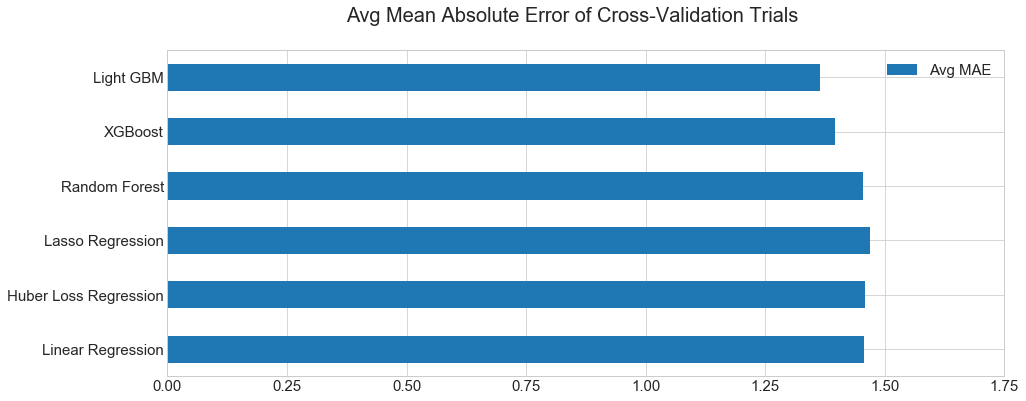

In [116]:
fig, ax = plt.subplots(figsize=(15, 6))
Scoring_df.plot(kind='barh', ax = ax)
ax.tick_params(labelsize=15)
plt.xticks(np.arange(0, 2, step=0.25))
ax.legend( prop={'size': 15})
A = fig.suptitle('Avg Mean Absolute Error of Cross-Validation Trials', fontsize=20)

# Residuals and Results

In [117]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import ValidationCurve

As we can see below, since the distribution of output variable (Separation) is so right skewed it is causing the distribution of our residuals to be skewed as well. In Linear Regression, one of the assumptions we make for our model to be valid is that the residuals are normally distributed. In this case, since the Mean Absolute Error for the Light Gradient Boosted model was the lowest (best), we do not need these assumptions to hold, as this is no longer linear regression.

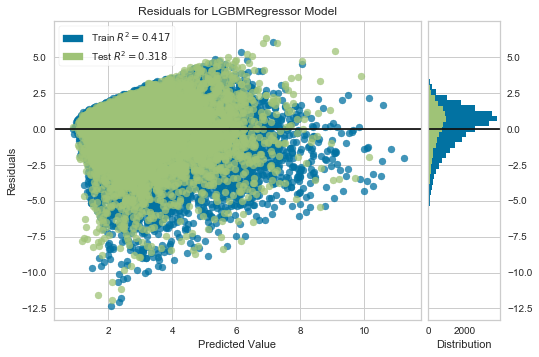

In [118]:
LGBM_fit = LGBM.fit(X_train_2, y_train_2)

visualizer = ResidualsPlot(LGBM_fit)
visualizer.fit(X_train_2, y_train_2)
visualizer.score(X_test, (y_test))
A = visualizer.show()

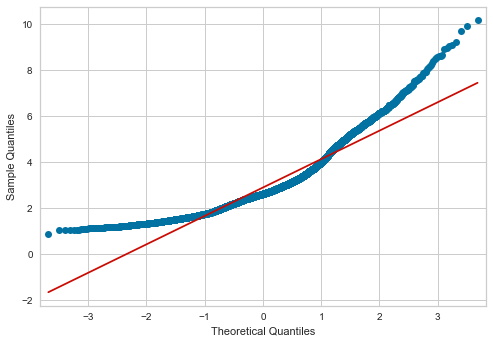

In [119]:
#QQ plot to show distribution of residuals
import statsmodels.api as sm

LGBM_fit.fit(X_train_2, y_train_2)
y_hat = LGBM_fit.predict(X_test)

# Create QQ plot
sm.qqplot(y_hat, line='s')
plt.show()


### Hyperparameter Tuning the Light Gradient Boosted Model

In [120]:
def objective(trial):
    dtrain = lgb.Dataset(X_train_2, label=y_train_2)
    dval = lgb.Dataset(X_val, label=y_val)

    param = {
        "objective": "regression",
        "metric": "l1",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds=100)
    preds = gbm.predict(X_val)
    MAE = mean_absolute_error(y_val, preds)
    return MAE

In [121]:
import optuna
import lightgbm as lgb

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

best_params = trial.params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.995526	valid_1's l1: 1.40186
Did not meet early stopping. Best iteration is:
[100]	training's l1: 0.995526	valid_1's l1: 1.40186


[I 2020-07-16 19:53:42,305] Finished trial#0 with value: 1.4018640256437505 with parameters: {'lambda_l1': 0.00042819408263767975, 'lambda_l2': 1.1264919705523873, 'num_leaves': 195, 'feature_fraction': 0.5489071164979875, 'bagging_fraction': 0.7770745733922829, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial#0 with value: 1.4018640256437505.


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.20663	valid_1's l1: 1.39909
Did not meet early stopping. Best iteration is:
[100]	training's l1: 1.20663	valid_1's l1: 1.39909


[I 2020-07-16 19:53:43,333] Finished trial#1 with value: 1.3990941080723143 with parameters: {'lambda_l1': 0.004603952839232341, 'lambda_l2': 0.002576415870124012, 'num_leaves': 68, 'feature_fraction': 0.5235594143343363, 'bagging_fraction': 0.4935369448601912, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial#1 with value: 1.3990941080723143.


Training until validation scores don't improve for 100 rounds


KeyboardInterrupt: 

In [ ]:
error_metric = 'l1'
objective = 'regression'
boosting_type = 'gbdt'
l1_val = 4.8660901332643364e-08
l2_val = 2.4642587535436775e-05
leaves = 47
feature_fraction = 0.7872361718025 #Model used 90% of the features we gave it
bagging_fraction = 0.8901174597537808
bagging_freq = 4
min_child_samp = 190

HC_best_params = {'objective': objective, 
                  'metric': error_metric ,
                  'boosting_type': boosting_type, 
                  'lambda_l1': l1_val, #Controls the l1 regularization parameter
                  'lambda_l2': l2_val, #Controls the l2 regularization parameter
                  'num_leaves': leaves, # number of leaf nodes to use, having a large number of leaves will improve accuracy, but can also lead to overfitting
                  'feature_fraction': feature_fraction, #controls the subsampling of features used for training
                  'bagging_fraction': bagging_fraction,
                  'bagging_freq': bagging_freq, 
                  'min_child_samples': min_child_samp #the minimum number of sample points (pass targets in this case) to group into a leaf 
                 }

## Fit the LGBM with best parameters

In [159]:
Final_LGBM = LGBMRegressor()


#Configure locally from hardcoded values
Final_LGBM.fit(X_train_2, y_train_2)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## How does our model do on our test data?

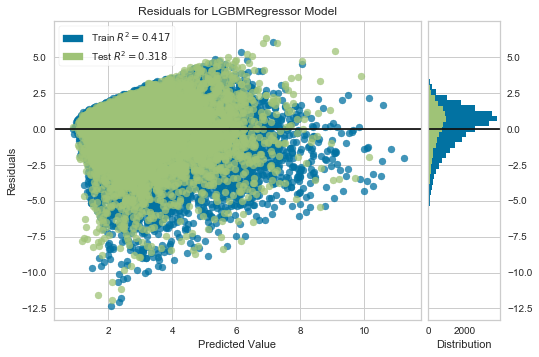

In [160]:
visualizer = ResidualsPlot(Final_LGBM)
visualizer.fit(X_train_2, y_train_2)
visualizer.score(X_test, (y_test))
A = visualizer.show()

In [161]:
y_test_hat = Final_LGBM.predict(X_test)
y_train_hat = Final_LGBM.predict(X_train)
test_MAE = mean_absolute_error(y_test, y_test_hat)
train_MAE = mean_absolute_error(y_train, y_train_hat)

print('The Training MAE was ' + str(train_MAE))
print('The Test MAE was ' + str(test_MAE))

The Training MAE was 1.284582664212841
The Test MAE was 1.3529927990125143


The mean absolute error of our test set is ~5% worse than that of out training set, but that is not terrible. It suggests that our model is slightly overfit to our training data, but for that sake of this project, I will not go any further in trying to lower the MAE of our test set.

In other ML modeling examples, however, I would take this feedback as an indicator that we have room to improve and would re-iterate on the model (feature engineering, hyperparameter tuning, feature selection) in order to create a more generalizable model that would perform at least as well, if not better, on the test set than the training set. 

In [125]:
X[float_cols] = Scaler.fit_transform(X[float_cols])

In [162]:
Final = Merged_Enc.copy()
index = Final.index
Final = df.loc[index] 
Final['Pred_Sep'] = Final_LGBM.predict(X)

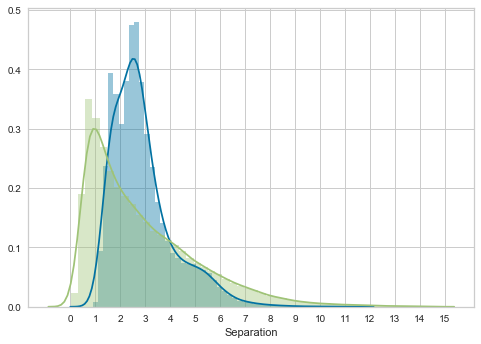

In [163]:
sns.distplot(Final['Pred_Sep'], kde_kws={'bw': .3})
sns.distplot(Final['Separation'], kde_kws={'bw': .3})
A =plt.xticks(range(-0, 16, 1))
# Add legend 

In [164]:
Final['Pred_Sep'].describe()

count    43539.000000
mean         2.891948
std          1.241614
min          0.899294
25%          2.016227
50%          2.621581
75%          3.367997
max         11.245280
Name: Pred_Sep, dtype: float64

In [165]:
Final['Separation'].describe()

count    43539.000000
mean         2.889469
std          2.205972
min          0.020000
25%          1.159526
50%          2.273785
75%          4.060788
max         14.472159
Name: Separation, dtype: float64

# Results!

In [166]:
import shap

In [167]:
%time 
shap_values = shap.TreeExplainer(Final_LGBM).shap_values(X)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


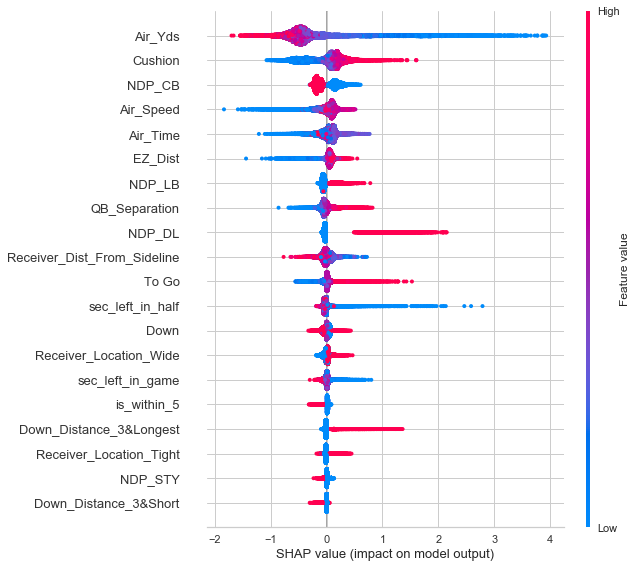

In [168]:
shap.summary_plot(shap_values, X)

The above [SHAP plot](https://github.com/slundberg/shap) gives an overview of how each feature contributed to the predicting separation on the whole. The Features (y-axis) are ordered by how often they were of significance to the prediction, with the most influential feature (Air Yards) at the top. The points themselves show how the value of each feauture was used to create the predictions. For example, when Air Yards values are low (blue) we can see that the model predicts a higher Separation (which, thankfully, makes sense). 

If we look at another feature, like NDP_DL (which is either a 1 or 0 value), it indicates that the model correctly understands that if the nearest defender was a DL on the play, it usually signified that the separation would higher, and therefore contributed to prediciting a higher separation value as well. 

## Examples 

In [169]:
explainer = shap.TreeExplainer(Final_LGBM)
Display = X.copy()
Display[float_cols] = Scaler.inverse_transform(Display[float_cols])
Display[skewed_feats] = np.expm1(Display[skewed_feats])
Display['Air_Yds'] = Display['Air_Yds'] - 20
Display[float_cols] = Display[float_cols].round(2)

In [170]:
Display.head()

,Qtr,Down,To Go,Cushion,Air_Yds,Air_Time,QB_Separation,Receiver_Dist_From_Sideline,EZ_Dist,missing_cushion,...,Down_Distance_3&Medium,Down_Distance_3&Short,Down_Distance_4&Long,Down_Distance_4&Longest,Down_Distance_4&Medium,Down_Distance_4&Short,NDP_CB,NDP_DL,NDP_LB,NDP_STY
39116,4,2,1,7.84,28.50,1.43,1.71,5.95,15.50,0,...,0,0,0,0,0,0,1,0,0,0
32132,1,2,1,8.34,-2.87,0.54,5.56,9.14,44.13,0,...,0,0,0,0,0,0,1,0,0,0
51076,2,3,1,5.36,0.04,0.71,4.12,14.14,44.04,0,...,0,1,0,0,0,0,1,0,0,0
51077,2,4,1,3.96,5.48,1.17,2.43,4.71,49.48,0,...,0,0,0,0,0,1,0,0,0,1
26653,3,4,1,7.23,3.76,0.83,2.92,5.29,49.24,0,...,0,0,0,0,0,1,1,0,0,0


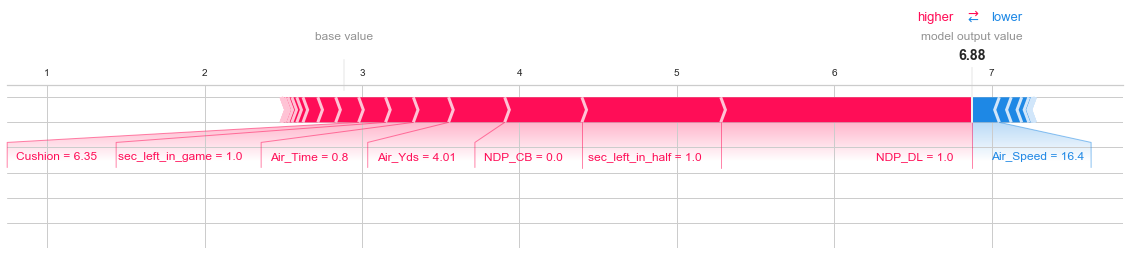

In [171]:
play = 10

shap.force_plot(explainer.expected_value, shap_values[play,:], Display.iloc[play,:], matplotlib = True)

In [172]:
#Actual Separation - Not Bad!
Final.iloc[10,:]['Separation']

11.22428131

On the above play, the model predicted that the player would have a **separation of 6.9 yards**. Intentional or not, the model picked up on the fact that in the waning moments of the game, since defenses know that all they need to defend are deep passes (hail mary type plays), plays that target receivers just 4 yards downfield aren't really a threat, and should warrant a large separation. Also, we notice that the nearest defender on the play was a DL (NDP_DL = 1), the model correctly predicted that he would have a separation far above average (which is 2.8 yards, as indicated by the words *base value* along the axis). 

On the play, the player had an **actual separation of 11.2 yards**. Not bad! In general, I would prefer a model to be more conservative, and not often predict values in the double-digits, so this is A-OK. 

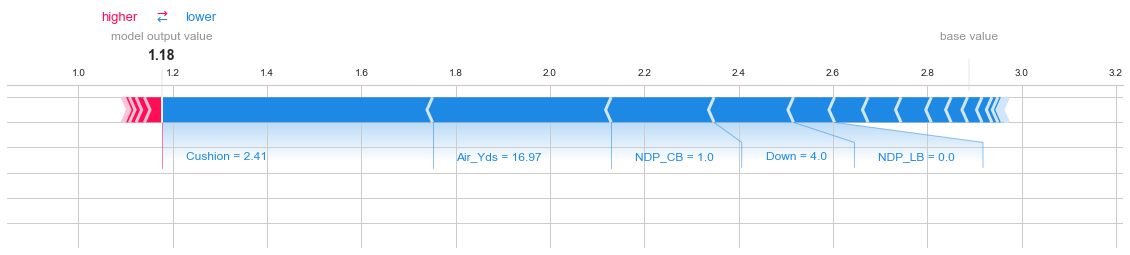

In [173]:
shap.force_plot(explainer.expected_value, shap_values[84,:], Display.iloc[84,:], matplotlib = True)

In [174]:
#Actual Separation - Also looks good!
Final.iloc[84,:]['Separation']

0.31890437

On this play, the model said that the player would have a **predicted separation of just 1.2 yards**. This was due to the fact that the receiver was given just 2.4 yards of cushion, was targeted 17 yards downfield, was covered by a CB, and it was 4th down and short. 

On the play, the player had an **actual separation of 0.3 yards**. Excellent!

# More Results!

In [175]:
Final = Final[['Season', 'Receiver', 'Nearest_Defender', 'Separation', 'Pred_Sep', 'TD', 'Pass Yds', 'INT', 'Cmp', 'Team', 'Air_Yds']]
Final['Sep_Diff'] = Final['Separation'] - Final['Pred_Sep']

In [176]:
COUNT_df = Final.groupby(['Receiver', 'Season']).nunique()
COUNT_df = COUNT_df.rename(columns = {'Separation':'Targets'})
COUNT_df = COUNT_df[['Targets']]
Final_df = Final.merge(COUNT_df, on = ['Receiver', 'Season'])

### Year over Year stability of Separation Differential

Below is a table showing how correlated a receivers average Separation Differential is year-over-year. Turns out, among receievers with at least 70 targets in each of the last 3 years, there is a low, but non-zero correlation between those figures over three seasons. Considering the variable nature of stats like these, I am okay with correlation values like these.

In [177]:
YoY = Final_df[Final_df['Targets'] >= 70]
YoY = YoY.groupby(['Receiver', 'Season'])[['Separation', 'Pred_Sep', 'Sep_Diff']].mean()
YoY = pd.pivot_table(YoY, values='Sep_Diff',index='Receiver', columns=['Season']).corr().round(3)
YoY

Season,2017,2018,2019
Season,,,
2017,1.000,0.318,0.313
2018,0.318,1.000,0.419
2019,0.313,0.419,1.000


### How do the players stack up?

In [178]:
Season = Final_df[['Receiver', 'Separation', 'Pred_Sep', 'Sep_Diff', 'Season', 'Targets']]
Season = Season.groupby(['Receiver', 'Season']).mean().reset_index().round(2)

In [179]:
#Create df since 2017

Since17 = Final[['Receiver', 'Separation', 'Pred_Sep', 'Sep_Diff']]
Since17_df = Since17.groupby(['Receiver']).mean().reset_index().round(2)
COUNT = Final.groupby(['Receiver']).nunique()
COUNT = COUNT.rename(columns = {'Separation':'Targets'})
COUNT_1 = COUNT[['Targets']]
Since17_df = Since17_df.merge(COUNT_1, on = ['Receiver'])

## Top 10 Highest Average Separation Above Expectation since 2017

In [180]:
Career = Since17_df[Since17_df['Targets'] > 150].sort_values(['Sep_Diff'], ascending = False)
Career.head(10)

,Receiver,Separation,Pred_Sep,Sep_Diff,Targets
584,Sammy Watkins,2.96,2.55,0.40,252
117,Chris Hogan,3.08,2.71,0.37,152
10,Albert Wilson,3.74,3.41,0.33,158
679,Will Fuller,2.96,2.64,0.33,173
666,Tyreek Hill,3.25,2.95,0.30,372
94,Calvin Ridley,3.02,2.74,0.28,184
180,Davante Adams,3.03,2.78,0.26,433
25,Amari Cooper,2.76,2.53,0.24,337
623,Ted Ginn,3.02,2.78,0.23,188
195,DeSean Jackson,2.77,2.55,0.22,172


## Top 10 Lowest Average Separation Above Expectation

In [181]:
Career.sort_values(['Sep_Diff'], ascending = True).head(10)

,Receiver,Separation,Pred_Sep,Sep_Diff,Targets
264,Golden Tate,2.67,3.09,-0.43,323
429,Larry Fitzgerald,2.60,3.00,-0.40,378
187,David Njoku,2.74,3.05,-0.31,157
561,Rob Gronkowski,2.40,2.71,-0.31,208
199,Delanie Walker,2.81,3.12,-0.30,160
98,Cameron Brate,2.59,2.88,-0.30,175
21,Allen Robinson,2.14,2.42,-0.29,261
413,Kenny Golladay,2.12,2.35,-0.23,274
372,Jordy Nelson,2.64,2.86,-0.22,175
349,Jimmy Graham,2.97,3.19,-0.21,248


## 2019 Only

In [182]:
df_2019 = Season[(Season['Targets'] > 75) & (Season['Season'] == 2019)].sort_values(['Sep_Diff'], ascending = False).reset_index(drop = True)
df_2019.head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
0,Diontae Johnson,2019,3.62,3.15,0.47,92
1,Davante Adams,2019,3.32,2.89,0.42,148
2,Tyreek Hill,2019,3.25,2.89,0.36,113
3,Sammy Watkins,2019,3.03,2.70,0.33,108
4,Sterling Shepard,2019,3.13,2.82,0.31,83
5,Will Fuller,2019,2.89,2.62,0.27,79
6,Travis Kelce,2019,3.05,2.79,0.26,157
7,Christian Kirk,2019,3.46,3.20,0.26,108
8,Austin Hooper,2019,3.39,3.14,0.25,96
9,Deebo Samuel,2019,3.17,2.94,0.23,97


In [183]:
df_2019.sort_values(['Sep_Diff'], ascending = True).head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
66,Golden Tate,2019,2.17,2.68,-0.52,85
65,Marvin Jones,2019,2.09,2.53,-0.45,91
64,Larry Fitzgerald,2019,2.98,3.33,-0.36,109
63,Julio Jones,2019,2.16,2.46,-0.30,156
62,Kenny Golladay,2019,1.95,2.22,-0.28,113
61,Allen Robinson,2019,2.25,2.46,-0.21,153
60,Auden Tate,2019,2.27,2.48,-0.21,80
59,Mike Gesicki,2019,2.61,2.81,-0.20,88
58,Zach Ertz,2019,2.75,2.96,-0.20,136
57,DeVante Parker,2019,2.03,2.22,-0.20,126


In [184]:
df_2019.sort_values(['Separation'], ascending = True).head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
62,Kenny Golladay,2019,1.95,2.22,-0.28,113
46,Mike Williams,2019,2.00,2.11,-0.10,90
57,DeVante Parker,2019,2.03,2.22,-0.20,126
65,Marvin Jones,2019,2.09,2.53,-0.45,91
56,Terry McLaurin,2019,2.11,2.30,-0.19,93
40,Darius Slayton,2019,2.16,2.23,-0.07,84
63,Julio Jones,2019,2.16,2.46,-0.30,156
66,Golden Tate,2019,2.17,2.68,-0.52,85
44,Robby Anderson,2019,2.17,2.27,-0.09,96
49,Michael Gallup,2019,2.21,2.35,-0.13,112


In [185]:
df_2019.sort_values(['Pred_Sep'], ascending = False).head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
18,Tyler Higbee,2019,3.70,3.52,0.17,88
54,George Kittle,2019,3.31,3.46,-0.16,114
64,Larry Fitzgerald,2019,2.98,3.33,-0.36,109
34,Robert Woods,2019,3.29,3.29,-0.00,137
53,Dallas Goedert,2019,3.10,3.26,-0.16,92
48,Darren Waller,2019,3.14,3.26,-0.12,117
33,Dede Westbrook,2019,3.22,3.21,0.01,100
7,Christian Kirk,2019,3.46,3.20,0.26,108
25,Jason Witten,2019,3.30,3.19,0.10,79
13,Cooper Kupp,2019,3.39,3.18,0.21,134


# Exceptional Separation Rate

For me, these numbers are a little underwhelming. No one is going to jump out of their seat to hear 'Davante Adams exceeds his predicted separation by .4 yards per target!' Well, I will, but let's see if we can't create something more digestable. Below I will create a stat called 'Exceptional Separation Rate' that tallies all the instances where a receiver exceeds their predicted separation by 2 yards, and divide that by their total targets to see how often they are beating the odds. 

In [186]:
Final_ES = Final.copy()
Final_ES['ES'] = 0
Final_ES['ES'].loc[Final_ES['Sep_Diff']> 0] = 1
Final_ES = Final_ES.merge(COUNT_1, on = ['Receiver'])
Final_ES = Final_ES[['Receiver', 'ES', 'Targets', 'Sep_Diff']]
Final_ES = Final_ES.groupby(['Receiver']).mean().round(2)
Final_ES = Final_ES.sort_values(['ES'], ascending = False)
Final_ES = Final_ES[Final_ES['Targets'] >= 160]
Final_ES.head(10)

,ES,Targets,Sep_Diff
Receiver,,,
Will Fuller,0.52,173.0,0.33
Davante Adams,0.51,433.0,0.26
DeSean Jackson,0.50,172.0,0.22
Cooper Kupp,0.50,296.0,0.19
Tyreek Hill,0.50,372.0,0.30
Ted Ginn,0.50,188.0,0.23
Calvin Ridley,0.49,184.0,0.28
Sammy Watkins,0.49,252.0,0.40
Christian Kirk,0.48,176.0,0.05


In [187]:
Final_ES.sort_values(['ES'], ascending = True).head(10)

,ES,Targets,Sep_Diff
Receiver,,,
Kenny Golladay,0.28,274.0,-0.23
Larry Fitzgerald,0.30,378.0,-0.40
Devin Funchess,0.32,202.0,-0.08
DeVante Parker,0.33,267.0,-0.17
Delanie Walker,0.33,160.0,-0.30
Mike Williams,0.33,194.0,-0.20
Golden Tate,0.33,323.0,-0.43
Cameron Brate,0.33,175.0,-0.30
Rob Gronkowski,0.34,208.0,-0.31


## Why should you care?

I **don't** want your takeaway here to see the above lists and think 'Kenny Golladay is Bad' or 'Sammy Watkins is amazing.'

The goal of this exercise is try and extract information from recevier separation, and the analysis doesn't end with these numbers. In an attmept to see how this stat looks on the team scale, I correlated *win percentage* over the last three seasons with the teams *average team separation differential* to see how this stat did to predict team success. 

In [188]:
WinPct = [.813, .750, .438, .563, .625, .438, .625, .375, .313, .875, .438, .750, 
          .688, .344, .500, .375, .500, .625, .438, .563, .438, .563, .500, .313, 
          .813, .438, .188, .125, .813, .250, .313, .219]

WP_AS = [.704, .551, .510, .490, .746, .451, .500, .560, .375, .673, .625, .354, 
         .660, .608, .440, .648, .277, .736, .540, .375, .566, .354, .647, .469, 
         .333, .500, .312, .354, .250, .510, .340, .383]

Teams = ['KC','GB','HOU','SF','NE','JAX','ATL','DAL','DEN','LA','PIT','TB','BAL',
         'SEA','IND','PHI','CLE','NO','LAC','MIA','TEN','OAK','MIN','CAR','NYJ',
         'BUF','CIN','WAS','NYG','CHI','ARI','DET']


d = {'Team': Teams, 'Win Pct': WP_AS}
Three_Year = pd.DataFrame(d)

In [193]:
Teams = Final[['Separation', 'Pred_Sep','Team']]
Teams['Sep_Diff'] = Teams['Separation'] - Teams['Pred_Sep']
Team_df = Teams.groupby(['Team']).mean().sort_values(['Sep_Diff'], ascending = False)
Combined = Team_df.merge(Three_Year, on = 'Team')
Combined.round(3).head(32)

,Team,Separation,Pred_Sep,Sep_Diff,Win Pct
0,KC,3.274,2.988,0.286,0.704
1,GB,3.195,3.056,0.138,0.551
2,JAX,2.974,2.900,0.074,0.451
3,HOU,2.902,2.829,0.072,0.510
4,NE,2.882,2.818,0.065,0.746
5,LA,3.140,3.076,0.064,0.673
6,SEA,2.924,2.861,0.063,0.608
7,IND,3.014,2.952,0.062,0.440
8,ATL,2.948,2.895,0.053,0.500
9,SF,2.986,2.943,0.042,0.490


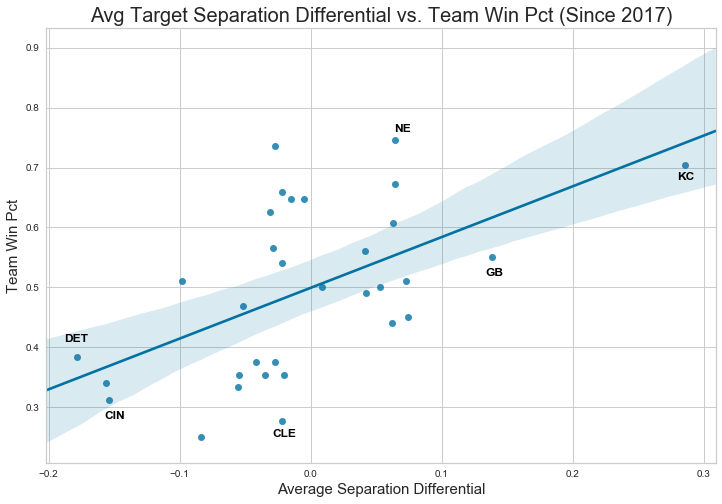

In [190]:
fig, ax = plt.subplots(figsize = (12,8))

fig = sns.regplot(x= 'Sep_Diff', y = 'Win Pct', data = Combined)

ax.set_title('Avg Target Separation Differential vs. Team Win Pct (Since 2017)', fontsize = 20)
ax.set_ylabel('Team Win Pct', fontsize = 15)
fig.text(.28, .68, "KC", horizontalalignment='left', size='medium', color='black', weight='semibold')
fig.text(-.17, .41, "DET", horizontalalignment='right', size='medium', color='black', weight='semibold')
fig.text(.14, .52, "GB", horizontalalignment='center', size='medium', color='black', weight='semibold')
fig.text(-.02, .25, "CLE", horizontalalignment='center', size='medium', color='black', weight='semibold')
fig.text(.07, .76, "NE", horizontalalignment='center', size='medium', color='black', weight='semibold')
fig.text(-.15, .28, "CIN", horizontalalignment='center', size='medium', color='black', weight='semibold')
A = ax.set_xlabel('Average Separation Differential', fontsize = 15)

Amazingly enough, teams with higher average separation differentials **won more often** than teams with lower separation differentials.

In [191]:
print('Correlation value of Team Winning Pct and Separation Differential: ' + str(Combined['Win Pct'].corr(Combined['Sep_Diff'], method = 'spearman').round(2)))

Correlation value of Team Winning Pct and Separation Differential: 0.55


I know what you are thinking, "*of course it is! receiver separation is a good thing, so teams with higher separation win more!*"

Yes, that is true, BUT, separation differential is actually a **better predictor of team success** than average separation. 

In [192]:
print('Correlation value of Team Winning Pct and Average Separtion: ' + str(Combined['Win Pct'].corr(Combined['Separation'], method = 'spearman').round(2)))


Correlation value of Team Winning Pct and Average Separtion: 0.48


In [236]:
Final_ES = Final.copy()
Final_ES['ES'] = 0
Final_ES['ES'].loc[Final_ES['Sep_Diff']> 0] = 1
Final_ES = Final_ES.merge(COUNT_1, on = ['Receiver'])
Final_ES = Final_ES[['Receiver', 'ES', 'Targets', 'Sep_Diff', 'Separation', 'Pred_Sep', 'Pass Yds', 'Air_Yds']]
Final_ES = Final_ES.groupby(['Receiver']).mean().round(3)
Final_ES = Final_ES[Final_ES['Targets'] >= 150]
Final_ES = Final_ES.sort_values(['ES'], ascending = False)
#Final_ES.head(20)

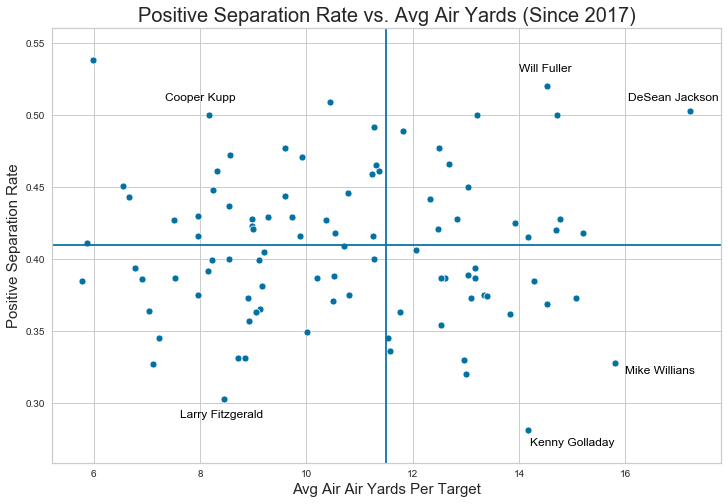

In [238]:
fig, ax = plt.subplots(figsize = (12,8))

fig = sns.scatterplot(x='Air_Yds', y ='ES', data = Final_ES)

ax.set_title('Positive Separation Rate vs. Avg Air Yards (Since 2017)', fontsize = 20)
ax.set_ylabel('Positive Separation Rate', fontsize = 15)
fig.text(16, .32, "Mike Willians", horizontalalignment='left', size='medium', color='black', weight='light')
fig.text(15.8, .27, "Kenny Golladay", horizontalalignment='right', size='medium', color='black', weight='light')
fig.text(14.5, .53, "Will Fuller", horizontalalignment='center', size='medium', color='black', weight='light')
fig.text(16.9, .51, "DeSean Jackson", horizontalalignment='center', size='medium', color='black', weight='light')
fig.text(8.4, .29, "Larry Fitzgerald", horizontalalignment='center', size='medium', color='black', weight='light')
fig.text(8, .51, "Cooper Kupp", horizontalalignment='center', size='medium', color='black', weight='light')
#fig.text(13.1, 3.1, "Tyler Lockett", horizontalalignment='center', size='medium', color='black', weight='light')
#fig.text(13, 3.3, "Tyreek Hill", horizontalalignment='left', size='medium', color='black', weight='light')
plt.axvline(x=11.5)
plt.axhline(y =0.41)
A = ax.set_xlabel('Avg Air Air Yards Per Target', fontsize = 15)


In [237]:
# Notes about how we should be comparing receivers by role, not by raw box score stats
# We should be comparing Cooper Kupp to Larry Fitz not vs Tyreek Hill
# Even though Kenny Golladay is a completely different body type to Fuller, they fill similar roles in their teams offenses (deep threat) and should be compared thusly

## Thanks for reading!

Thank you all for reading. If you have any questions, suggestions, or any feedback at all, feel free to reach out at JesseDCohen@gmail.com. 